In [78]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory, LangDetectException
import matplotlib.pyplot as plt
import spacy
from deep_translator import GoogleTranslator
from googletrans import Translator
from bson.objectid import ObjectId
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from joblib import Parallel, delayed
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ekate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
client = MongoClient('localhost', 27017)
collectionMongo_raw = client['VKR1']['research_paper']
collectionMongo = client['VKR1']['Proccessed_research']  

# Предварительный анализ данных и подготовка

In [4]:
data = list(collectionMongo_raw.find())
df = pd.DataFrame(data)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118913 entries, 0 to 118912
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   _id                 118913 non-null  object
 1   acceptedDate        7286 non-null    object
 2   authors             118913 non-null  object
 3   contributors        118913 non-null  object
 4   createdDate         118913 non-null  object
 5   depositedDate       11543 non-null   object
 6   abstract            118913 non-null  object
 7   documentType        118913 non-null  object
 8   doi                 51474 non-null   object
 9   downloadUrl         118913 non-null  object
 10  fieldOfStudy        3146 non-null    object
 11  title               118913 non-null  object
 12  language            69018 non-null   object
 13  publishedDate       118913 non-null  object
 14  publisher           118913 non-null  object
 15  references          118913 non-null  object
 16  so

## 1.1. Анализ признака yearPublished

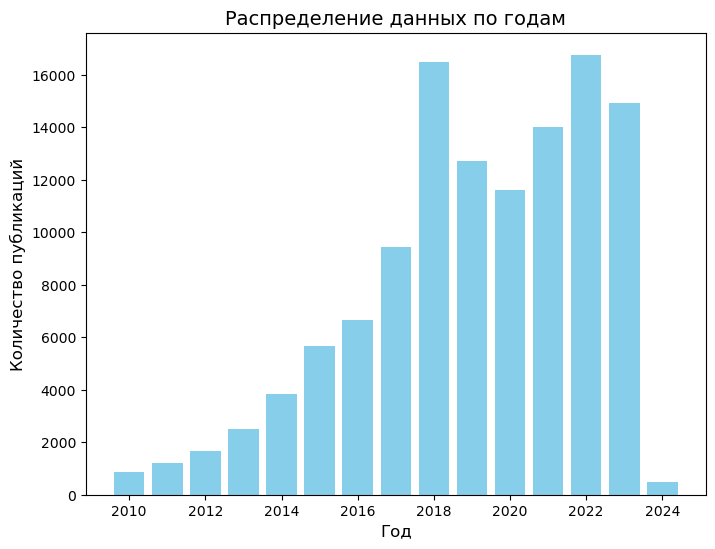

In [7]:
year_counts = df['yearPublished'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество публикаций', fontsize=12)
plt.title('Распределение данных по годам', fontsize=14)
plt.show()

Так как цель работы - выявление тенденций развития области анализа больших данных, возьмем актуальные данные, начиная от 2018 года

In [9]:
df = df[df['yearPublished'] > 2017]


In [10]:
df['yearPublished'].unique()

array([2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype=int64)

## 1.2. Анализ признака abstract

In [12]:
word_counts_clean = []
for doc in df['abstract']:
    word_count = len(doc)
    word_counts_clean.append(word_count)

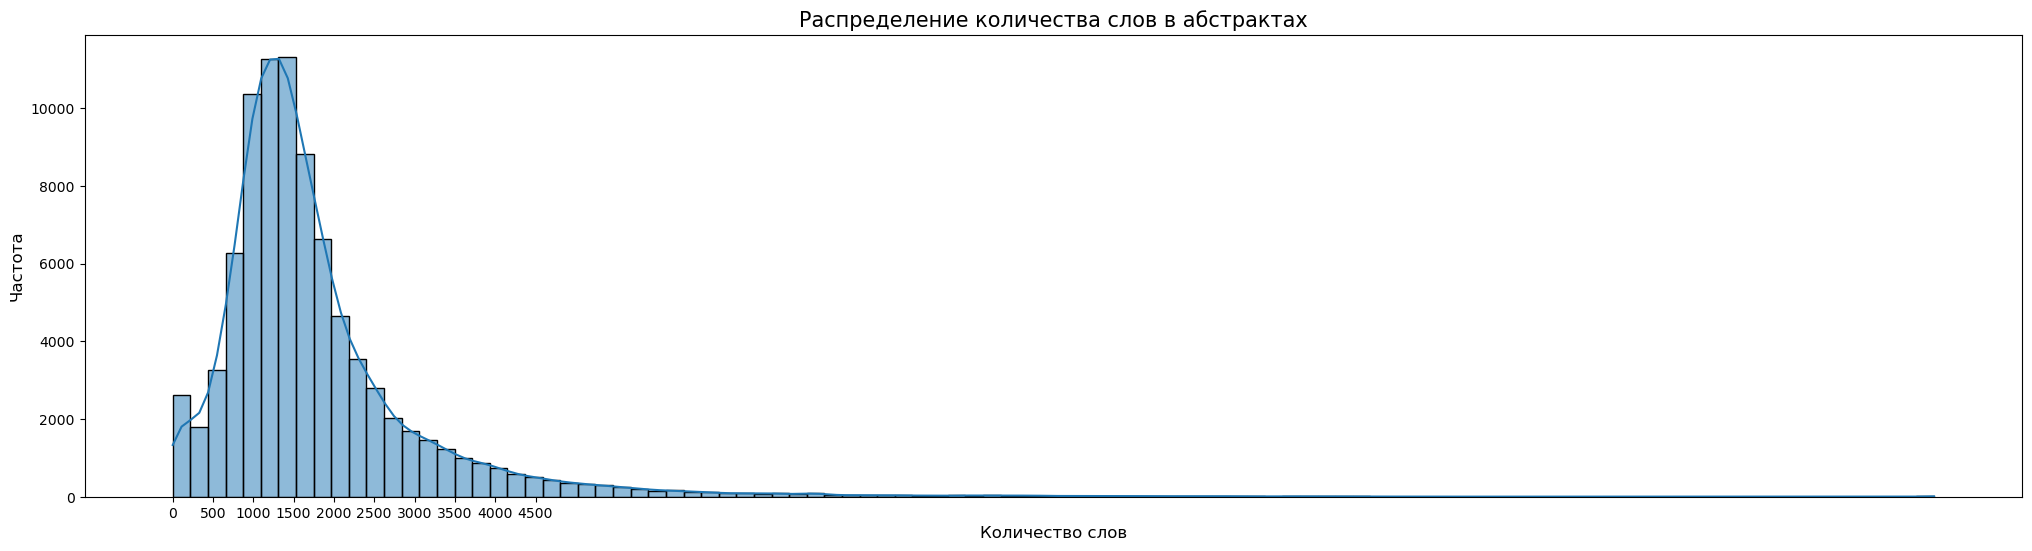

In [13]:
plt.figure(figsize=(25, 6))

sns.histplot(word_counts_clean, bins=100, kde=True)
plt.xticks(np.arange(0, 5000, 500))

plt.title('Распределение количества слов в абстрактах', fontsize=15)
plt.xlabel('Количество слов', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.show()

## 1.3. Анализ признака "language"

In [19]:
#Оставим только "код" языка вместо коллекции данных

df['language'] = df['language'].str.get('code')

In [21]:
# Выведем уникальные значения language

df['language'].unique()

array(['en', nan, 'es', 'hr', 'pt', 'zz', 'nl', 'ru', 'id', 'fr', 'uk',
       'it', 'de', 'fi', 'pl', 'el', 'zh-cn', 'ca', 'hu', 'et', 'ko',
       'lt', 'nb', 'tr', 'yo', 'cs', 'da', 'sl', 'no', 'sq', 'eu', 'sr',
       'bg', 'ja', 'th', 'gl', 'sv', 'ro', 'sk', 'zy', 'eo', 'mk', 'ar',
       'af', 'fa', 'bs'], dtype=object)

In [23]:
# Количество нехаполненных значений language

len(df.loc[pd.isna(df['language'])==True])

33156

Внимательно посмотрев примеры абстрактов, можно заметить, что авторы исследований публикуют абстракты сразу на нескольких языках. Для исключения таких случаев была напишем функцию обработки текстов

Также объединим название статей и абстракты

In [31]:
df['title_abstract'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

In [45]:
import re
from langdetect import detect, LangDetectException
from langdetect import DetectorFactory

# Устанавливаем seed для консистентности результатов определения языка
DetectorFactory.seed = 0
preferred_language = 'en'

def filter_abstract_optimized(abstract_text):
    # Проверка, чтобы текст не был пустым или слишком коротким
    if not abstract_text or len(abstract_text.strip()) < 20:
        return abstract_text

    try:
        # Определение языка всего текста
        detected_lang = detect(abstract_text)
    except LangDetectException:
        return abstract_text

    # Если язык не английский, обрабатываем предложения
    if detected_lang != preferred_language:
        # Разделение текста на предложения
        sentences = re.split(r'(?<=[.!?])\s+', abstract_text.strip())

        filtered_sentences = []
        for sentence in sentences:
            # Пропуск предложений, которые слишком короткие для определения языка
            if len(sentence.strip()) < 10:
                continue

            try:
                if detect(sentence) == preferred_language:
                    filtered_sentences.append(sentence)
            except LangDetectException:
                continue

        return ' '.join(filtered_sentences) if filtered_sentences else abstract_text
    else:
        # Если язык уже английский, возвращаем текст без изменений
        return abstract_text
        
# Применение к DataFrame с использованием progress_apply для отслеживания прогресса
df['lang_clean_abstract_title'] = df['title_abstract'].progress_apply(filter_abstract_optimized)

100%|██████████| 87043/87043 [21:47<00:00, 66.57it/s]  


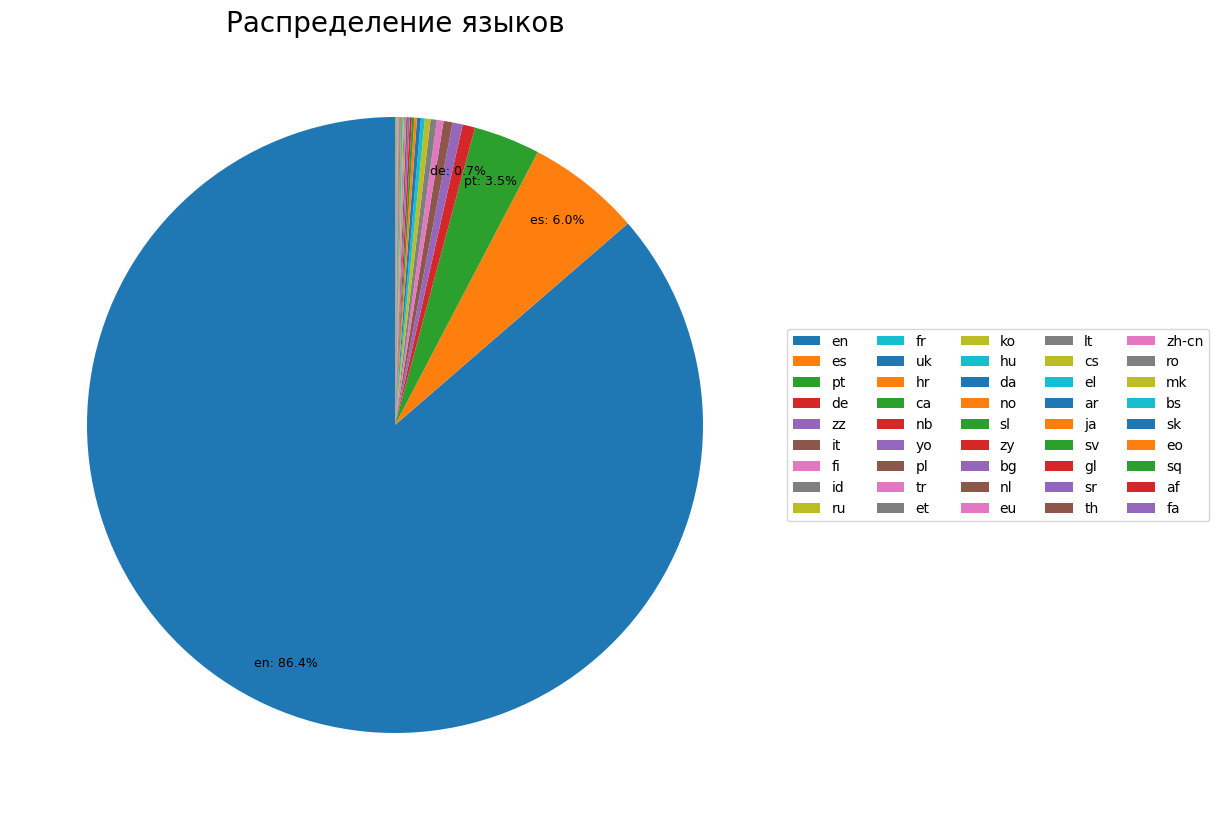

In [49]:
language_counts = df['language'].value_counts()

top_n = 4
top_values = language_counts.nlargest(top_n)

def autopct_func(pct, allvals):
    total = sum(allvals)
    value = int(np.round(pct * total / 100.0))
    if value in top_values.values:
        label = language_counts.index[np.where(language_counts.values == value)[0][0]]
        return f'{label}: {pct:.1f}%'  
    else:
        return '' 

plt.figure(figsize=(10, 10))  
plt.pie(language_counts, 
        autopct=lambda pct: autopct_func(pct, language_counts.values),  
        startangle=90, 
        textprops={'fontsize': 9}, 
        pctdistance=0.85, 
        labeldistance=1.1) 


plt.legend(labels=language_counts.index, loc='center left', 
           bbox_to_anchor=(1, 0.5), ncol=(len(language_counts) // 10 + 1), fontsize=10)

plt.title('Распределение языков', fontsize=20)
plt.show()


In [82]:
def detect_lang_empty(text):
    if pd.isna(text) or text.strip() == '':
        return None  
    try:
        return detect(text)  
    except LangDetectException:
        return None 

In [86]:
df['language'] = df.progress_apply(
    lambda row: detect_lang_empty(row['lang_clean_abstract_title']) if pd.isna(row['language']) else row['language'],
    axis=1
)

100%|██████████| 87043/87043 [03:28<00:00, 417.58it/s] 


# ПРЕДОБРАБОТКА

In [52]:
df = df[df['lang_clean_abstract_title'].notna() & (df['lang_clean_abstract_title'] != '')]

Создадим функцию, включающую в себя основные этапы подготовки текстовых данных:

1. Первый этап заключается в очистке текстов от ненужных символов, лишних пробелов, URL-адресов,  тегов и др.
2. Подготовка текстов, необходимых к переводу на английский язык. Учитывая ограничения в максимальную длину 5000 символов, а также принимая во внимание распределение длины абстрактов (5000 символов встречается в минимальном количестве абстрактов, поэтому на качество текстовых данных и потерю информации влияния не будет), тексты обрезаются до 4999 символов для корректности выполнения перевода.
3. Если текст написан на языке, отличном от английского, он переводится на английский язык. 
Так как в выборке входных данных представлены научные работы на 53 языках, тексты, отличные от  английского будут переводиться на английский язык с помощью автоматического переводчика. Таким образом, обеспечивается унифицированность данных.
4. На завершающем этапе осуществляется лемматизация и исключение стоп-слов. Учитывая особенности текстовых данных, полученные на этапе предварительного анализа, решено использовать модели en_core_web_sm для английского языкаpaCy.

In [90]:
# Подключение к MongoDB
collectionMongo = client['VKR1']['proccessed_for_topic_modelling']

# Загрузка моделей spaCy
nlp_en = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Отключаем ненужные компоненты
translator = GoogleTranslator(source='auto', target='en')  # Настройка deep_translator

def preprocess_text(text, language, doc_id):
    """
    Обрабатывает текст: очищает, переводит и возвращает результаты.
    """
    # Предварительная обработка текста
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Удаление ссылок
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Удаление эмодзи и символов юникода
    text = re.sub(r'[^\w\s]', '', text)  # Удаление нежелательных символов
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов

    # Обрезка текста, если он слишком длинный
    if len(text) > 5000:
        text = text[:4999]
        print(f"Абстракт с ID {doc_id} был обрезан до 5000 символов.")

    # Перевод текста на английский, если язык не английский
    if language != 'en':
        try:
            text = translator.translate(text)
        except Exception as e:
            print(f"Ошибка перевода для ID {doc_id}: {e}")
            return None, None  # Возвращаем None в случае ошибки

    # Лемматизация и удаление стоп-слов
    doc = nlp_en(text)
    processed_words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    processed_text = ' '.join(processed_words)

    return text, processed_text

def batch_process_and_save(df, batch_size=100):
    """
    Обрабатывает документы в батчах и сохраняет результаты в MongoDB.
    """
    for i in tqdm(range(0, len(df), batch_size), desc="Обработка батчей"):
        batch = df.iloc[i:i + batch_size]
        updates = []

        for _, row in batch.iterrows():
            processed_data = preprocess_text(row['lang_clean_abstract_title'], row['language'], row['_id'])
            if processed_data:
                text, processed_text = processed_data
                if text and processed_text:  # Проверяем, что обработка прошла успешно
                    updates.append({
                        "filter": {"_id": ObjectId(row['_id'])},
                        "update": {
                            "$set": {
                                "abstract_bert_emb": text,
                                "processed": processed_text
                            }
                        }
                    })

        # Выполняем обновления в базе данных
        if updates:
            try:
                for update in updates:
                    collectionMongo.update_one(update["filter"], update["update"], upsert=True)
            except Exception as e:
                print(f"Ошибка записи в MongoDB: {e}")

# Обработка DataFrame
batch_process_and_save(df, batch_size=100)

Обработка батчей:   1%|          | 5/871 [00:27<1:26:11,  5.97s/it]

Абстракт с ID 661a5e4e3910d146349279f5 был обрезан до 5000 символов.
Абстракт с ID 661a5e4e3910d14634927a43 был обрезан до 5000 символов.


Обработка батчей:   1%|          | 7/871 [00:35<1:09:00,  4.79s/it]

Абстракт с ID 661a5e563910d14634927ad2 был обрезан до 5000 символов.


Обработка батчей:   1%|          | 8/871 [00:39<1:04:06,  4.46s/it]

Абстракт с ID 661a5e563910d14634927b35 был обрезан до 5000 символов.


Обработка батчей:   1%|▏         | 12/871 [00:51<49:39,  3.47s/it] 

Абстракт с ID 661a5e563910d14634927ce8 был обрезан до 5000 символов.


Обработка батчей:   2%|▏         | 15/871 [01:05<1:03:21,  4.44s/it]

Абстракт с ID 661a5e6a3910d14634927e14 был обрезан до 5000 символов.


Обработка батчей:   2%|▏         | 17/871 [01:17<1:09:57,  4.91s/it]

Абстракт с ID 661a5e6a3910d14634927ef0 был обрезан до 5000 символов.
Абстракт с ID 661a5e6a3910d14634927efa был обрезан до 5000 символов.


Обработка батчей:   3%|▎         | 25/871 [02:18<2:05:31,  8.90s/it]

Абстракт с ID 661a5e793910d146349281dc был обрезан до 5000 символов.


Обработка батчей:   3%|▎         | 27/871 [02:31<1:51:03,  7.90s/it]

Абстракт с ID 661a5e793910d146349282a8 был обрезан до 5000 символов.
Абстракт с ID 661a5e793910d146349282b3 был обрезан до 5000 символов.


Обработка батчей:   3%|▎         | 28/871 [02:40<1:54:43,  8.17s/it]

Абстракт с ID 661a5e793910d14634928301 был обрезан до 5000 символов.


Обработка батчей:   3%|▎         | 29/871 [02:56<2:30:45, 10.74s/it]

Абстракт с ID 661a5e793910d14634928358 был обрезан до 5000 символов.
Абстракт с ID 661a5e793910d1463492839a был обрезан до 5000 символов.


Обработка батчей:   4%|▎         | 31/871 [03:11<2:02:45,  8.77s/it]

Абстракт с ID 661a5e8f3910d1463492842b был обрезан до 5000 символов.


Обработка батчей:   4%|▎         | 32/871 [03:22<2:13:31,  9.55s/it]

Абстракт с ID 661a5e8f3910d14634928489 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d1463492848d был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 33/871 [03:28<1:58:48,  8.51s/it]

Абстракт с ID 661a5e8f3910d146349284e9 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349284f6 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349284fc был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 34/871 [03:34<1:49:33,  7.85s/it]

Абстракт с ID 661a5e8f3910d14634928571 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928573 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928575 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928580 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d1463492859f был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285a8 был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 35/871 [03:42<1:48:13,  7.77s/it]

Абстракт с ID 661a5e8f3910d146349285b2 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285b3 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285ba был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285cd был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285cf был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349285d2 был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 36/871 [03:53<2:00:00,  8.62s/it]

Абстракт с ID 661a5e8f3910d1463492860f был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928617 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d1463492861b был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d1463492862b был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928636 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928646 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d14634928656 был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 37/871 [04:06<2:19:05, 10.01s/it]

Абстракт с ID 661a5e8f3910d1463492867d был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349286b0 был обрезан до 5000 символов.
Абстракт с ID 661a5e8f3910d146349286b7 был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 38/871 [04:11<1:57:14,  8.44s/it]

Абстракт с ID 661a5ea23910d146349286f5 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928704 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928715 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928732 был обрезан до 5000 символов.


Обработка батчей:   4%|▍         | 39/871 [04:29<2:38:01, 11.40s/it]

Абстракт с ID 661a5ea23910d1463492875c был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928762 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928763 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928764 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928765 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928766 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928767 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492876b был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492876c был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492876d был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492876e был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492877a был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492877d был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928789 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d1463492

Обработка батчей:   5%|▍         | 41/871 [04:47<2:16:48,  9.89s/it]

Абстракт с ID 661a5ea23910d14634928844 был обрезан до 5000 символов.


Обработка батчей:   5%|▍         | 43/871 [04:52<1:22:57,  6.01s/it]

Абстракт с ID 661a5ea23910d146349288fd был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928914 был обрезан до 5000 символов.
Абстракт с ID 661a5ea23910d14634928917 был обрезан до 5000 символов.


Обработка батчей:   5%|▌         | 44/871 [04:54<1:06:15,  4.81s/it]

Абстракт с ID 661a5eea3910d1463492897e был обрезан до 5000 символов.


Обработка батчей:   5%|▌         | 46/871 [05:12<1:37:36,  7.10s/it]

Абстракт с ID 661a5eea3910d14634928a30 был обрезан до 5000 символов.
Абстракт с ID 661a5eea3910d14634928a65 был обрезан до 5000 символов.


Обработка батчей:   5%|▌         | 47/871 [05:24<1:55:39,  8.42s/it]

Абстракт с ID 661a5eea3910d14634928a82 был обрезан до 5000 символов.


Обработка батчей:   6%|▌         | 50/871 [05:59<2:15:03,  9.87s/it]

Абстракт с ID 661a5ef43910d14634928bdc был обрезан до 5000 символов.


Обработка батчей:   6%|▌         | 52/871 [06:19<2:10:19,  9.55s/it]

Абстракт с ID 661a5ef43910d14634928cac был обрезан до 5000 символов.
Абстракт с ID 661a5ef43910d14634928cb1 был обрезан до 5000 символов.


Обработка батчей:   6%|▌         | 53/871 [06:36<2:43:26, 11.99s/it]

Абстракт с ID 661a5ef43910d14634928ccc был обрезан до 5000 символов.
Абстракт с ID 661a5ef43910d14634928cef был обрезан до 5000 символов.
Абстракт с ID 661a5ef43910d14634928cf2 был обрезан до 5000 символов.
Абстракт с ID 661a5ef43910d14634928d0a был обрезан до 5000 символов.
Абстракт с ID 661a5f003910d14634928d1a был обрезан до 5000 символов.


Обработка батчей:   6%|▌         | 54/871 [06:49<2:47:10, 12.28s/it]

Абстракт с ID 661a5f003910d14634928d26 был обрезан до 5000 символов.
Абстракт с ID 661a5f003910d14634928d2a был обрезан до 5000 символов.
Абстракт с ID 661a5f003910d14634928d67 был обрезан до 5000 символов.


Обработка батчей:   6%|▋         | 55/871 [06:53<2:14:17,  9.87s/it]

Абстракт с ID 661a5f003910d14634928da9 был обрезан до 5000 символов.


Обработка батчей:   6%|▋         | 56/871 [06:58<1:53:15,  8.34s/it]

Абстракт с ID 661a5f003910d14634928e07 был обрезан до 5000 символов.
Абстракт с ID 661a5f003910d14634928e21 был обрезан до 5000 символов.


Обработка батчей:   7%|▋         | 58/871 [07:12<1:47:29,  7.93s/it]

Абстракт с ID 661a5f003910d14634928edc был обрезан до 5000 символов.


Обработка батчей:   7%|▋         | 59/871 [07:20<1:48:13,  8.00s/it]

Абстракт с ID 661a5f003910d14634928f4d был обрезан до 5000 символов.


Обработка батчей:   7%|▋         | 61/871 [07:33<1:34:07,  6.97s/it]

Абстракт с ID 661a5f123910d1463492900a был обрезан до 5000 символов.


Обработка батчей:   7%|▋         | 63/871 [07:49<1:40:40,  7.48s/it]

Абстракт с ID 661a5f123910d146349290b7 был обрезан до 5000 символов.


Обработка батчей:   7%|▋         | 64/871 [07:55<1:31:36,  6.81s/it]

Абстракт с ID 661a5f123910d14634929120 был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 66/871 [08:16<1:53:06,  8.43s/it]

Абстракт с ID 661a5f123910d1463492921f был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 67/871 [08:28<2:08:20,  9.58s/it]

Абстракт с ID 661a5f243910d14634929258 был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 68/871 [08:45<2:39:23, 11.91s/it]

Абстракт с ID 661a5f243910d146349292a9 был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 69/871 [08:57<2:36:55, 11.74s/it]

Абстракт с ID 661a5f243910d1463492933b был обрезан до 5000 символов.
Абстракт с ID 661a5f243910d1463492933f был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 70/871 [09:12<2:52:07, 12.89s/it]

Абстракт с ID 661a5f243910d14634929374 был обрезан до 5000 символов.
Абстракт с ID 661a5f243910d146349293bc был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 71/871 [09:25<2:50:53, 12.82s/it]

Абстракт с ID 661a5f243910d1463492942c был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 72/871 [09:40<2:58:55, 13.44s/it]

Абстракт с ID 661a5f243910d14634929443 был обрезан до 5000 символов.
Абстракт с ID 661a5f243910d14634929465 был обрезан до 5000 символов.
Абстракт с ID 661a5f243910d14634929473 был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 73/871 [09:57<3:13:37, 14.56s/it]

Абстракт с ID 661a5f243910d146349294ce был обрезан до 5000 символов.
Абстракт с ID 661a5f243910d146349294f3 был обрезан до 5000 символов.


Обработка батчей:   8%|▊         | 74/871 [10:12<3:14:13, 14.62s/it]

Абстракт с ID 661a5f3d3910d1463492954f был обрезан до 5000 символов.


Обработка батчей:   9%|▊         | 75/871 [10:32<3:33:55, 16.13s/it]

Абстракт с ID 661a5f3d3910d146349295a3 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d146349295aa был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d146349295b2 был обрезан до 5000 символов.
Ошибка перевода для ID 661a5f3d3910d146349295b2: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661a5f3d3910d146349295b8 был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 77/871 [10:59<3:16:43, 14.87s/it]

Абстракт с ID 661a5f3d3910d1463492965b был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d14634929686 был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 78/871 [11:18<3:30:02, 15.89s/it]

Абстракт с ID 661a5f3d3910d146349296cd был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d146349296e3 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d146349296ea был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 79/871 [11:39<3:52:42, 17.63s/it]

Абстракт с ID 661a5f3d3910d146349296f9 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d14634929703 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d14634929712 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d1463492973c был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 80/871 [12:01<4:08:35, 18.86s/it]

Абстракт с ID 661a5f3d3910d14634929786 был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 81/871 [12:23<4:22:09, 19.91s/it]

Абстракт с ID 661a5f3d3910d146349297e3 был обрезан до 5000 символов.
Абстракт с ID 661a5f3d3910d146349297ea был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929807 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929809 был обрезан до 5000 символов.


Обработка батчей:   9%|▉         | 82/871 [12:41<4:12:52, 19.23s/it]

Абстракт с ID 661a5f563910d1463492986f был обрезан до 5000 символов.


Обработка батчей:  10%|▉         | 83/871 [13:00<4:12:39, 19.24s/it]

Абстракт с ID 661a5f563910d14634929893 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d1463492989d был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349298a0 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349298c7 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349298dd был обрезан до 5000 символов.


Обработка батчей:  10%|▉         | 84/871 [13:20<4:15:26, 19.48s/it]

Абстракт с ID 661a5f563910d146349298f1 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d1463492992c был обрезан до 5000 символов.


Обработка батчей:  10%|▉         | 85/871 [13:51<4:56:53, 22.66s/it]

Абстракт с ID 661a5f563910d14634929954 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929973 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d1463492997f был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929980 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929986 был обрезан до 5000 символов.


Обработка батчей:  10%|▉         | 86/871 [14:15<5:04:13, 23.25s/it]

Абстракт с ID 661a5f563910d146349299ba был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349299bd был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349299d3 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d146349299e4 был обрезан до 5000 символов.


Обработка батчей:  10%|▉         | 87/871 [14:32<4:40:34, 21.47s/it]

Абстракт с ID 661a5f563910d14634929a1c был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929a6d был обрезан до 5000 символов.


Обработка батчей:  10%|█         | 88/871 [14:52<4:34:07, 21.01s/it]

Абстракт с ID 661a5f563910d14634929a79 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929a93 был обрезан до 5000 символов.
Абстракт с ID 661a5f563910d14634929ab2 был обрезан до 5000 символов.


Обработка батчей:  10%|█         | 89/871 [15:09<4:16:35, 19.69s/it]

Абстракт с ID 661a5f783910d14634929b0a был обрезан до 5000 символов.


Обработка батчей:  10%|█         | 90/871 [15:32<4:28:14, 20.61s/it]

Абстракт с ID 661a5f783910d14634929b78 был обрезан до 5000 символов.


Обработка батчей:  10%|█         | 91/871 [15:45<3:58:19, 18.33s/it]

Абстракт с ID 661a5f783910d14634929bec был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 92/871 [15:57<3:33:09, 16.42s/it]

Абстракт с ID 661a5f783910d14634929c18 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929c25 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929c38 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929c3c был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929c50 был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 93/871 [16:23<4:11:47, 19.42s/it]

Абстракт с ID 661a5f783910d14634929cb9 был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 94/871 [16:50<4:38:28, 21.50s/it]

Абстракт с ID 661a5f783910d14634929d2a был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929d33 был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 95/871 [17:17<5:00:25, 23.23s/it]

Абстракт с ID 661a5f783910d14634929d3b был обрезан до 5000 символов.
Ошибка перевода для ID 661a5f783910d14634929d5d: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661a5f783910d14634929d66 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929d84 был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 96/871 [17:36<4:44:29, 22.03s/it]

Абстракт с ID 661a5f783910d14634929d98 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929d9b был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929de0 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929df0 был обрезан до 5000 символов.
Абстракт с ID 661a5f783910d14634929df7 был обрезан до 5000 символов.


Обработка батчей:  11%|█         | 97/871 [17:51<4:16:11, 19.86s/it]

Абстракт с ID 661a5f783910d14634929e0b был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e28 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e39 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e4b был обрезан до 5000 символов.


Обработка батчей:  11%|█▏        | 98/871 [18:17<4:39:29, 21.69s/it]

Абстракт с ID 661a5fa23910d14634929e6a был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e71 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e7c был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e91 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929e96 был обрезан до 5000 символов.


Обработка батчей:  11%|█▏        | 99/871 [18:41<4:49:32, 22.50s/it]

Абстракт с ID 661a5fa23910d14634929ecb был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929ed0 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929edc был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929ef8 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929f1c был обрезан до 5000 символов.


Обработка батчей:  11%|█▏        | 100/871 [19:01<4:39:51, 21.78s/it]

Абстракт с ID 661a5fa23910d14634929f49 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929f74 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929f82 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929f85 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 101/871 [19:23<4:41:13, 21.91s/it]

Абстракт с ID 661a5fa23910d14634929f8f был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929f9e был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fa7 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fb2 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fba был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fd5 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fda был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d14634929fdc был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 102/871 [19:54<5:12:45, 24.40s/it]

Абстракт с ID 661a5fa23910d1463492a042 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 103/871 [20:27<5:44:42, 26.93s/it]

Абстракт с ID 661a5fa23910d1463492a091 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d1463492a0a2 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 104/871 [20:51<5:36:04, 26.29s/it]

Абстракт с ID 661a5fa23910d1463492a0bf был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d1463492a0eb был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d1463492a0f5 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d1463492a100 был обрезан до 5000 символов.
Абстракт с ID 661a5fa23910d1463492a113 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 105/871 [21:17<5:33:21, 26.11s/it]

Абстракт с ID 661a5fdb3910d1463492a150 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a15b был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a162 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a174 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 106/871 [21:48<5:52:35, 27.65s/it]

Абстракт с ID 661a5fdb3910d1463492a1ae был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a1b8 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a1c8 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a1d3 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a1db был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a1e0 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 107/871 [22:18<6:01:21, 28.38s/it]

Абстракт с ID 661a5fdb3910d1463492a21c был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a247 был обрезан до 5000 символов.


Обработка батчей:  12%|█▏        | 108/871 [22:56<6:37:57, 31.29s/it]

Абстракт с ID 661a5fdb3910d1463492a24c был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a261 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a285 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a293 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a294 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a2a1 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 109/871 [23:27<6:34:26, 31.06s/it]

Абстракт с ID 661a5fdb3910d1463492a2ce был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a2db был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a2f2 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a310 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 110/871 [23:54<6:20:09, 29.97s/it]

Абстракт с ID 661a5fdb3910d1463492a340 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a348 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a360 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 111/871 [24:25<6:20:59, 30.08s/it]

Абстракт с ID 661a5fdb3910d1463492a384 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a385 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a39a был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3af был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3c5 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3cb был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3d0 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3d4 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 112/871 [24:48<5:54:00, 27.98s/it]

Абстракт с ID 661a5fdb3910d1463492a3e2 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3ed был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3f2 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3f7 был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3fa был обрезан до 5000 символов.
Абстракт с ID 661a5fdb3910d1463492a3fe был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a42e был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a437 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 113/871 [25:22<6:18:27, 29.96s/it]

Ошибка перевода для ID 661a60143910d1463492a461: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661a60143910d1463492a46e был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a481 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a490 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a495 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a49e был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a4a0 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 114/871 [25:49<6:03:39, 28.82s/it]

Абстракт с ID 661a60143910d1463492a4b3 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a4b7 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a4fc был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a507 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a50a был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 115/871 [26:26<6:37:24, 31.54s/it]

Абстракт с ID 661a60143910d1463492a50b был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a50c был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a515 был обрезан до 5000 символов.
Ошибка перевода для ID 661a60143910d1463492a51f: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661a60143910d1463492a525 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a52f был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a532 был обрезан до 5000 символов.


Обработка батчей:  13%|█▎        | 116/871 [27:19<7:55:39, 37.80s/it]

Абстракт с ID 661a60143910d1463492a57d был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a586 был обрезан до 5000 символов.


Обработка батчей:  14%|█▎        | 118/871 [28:05<6:01:04, 28.77s/it]

Абстракт с ID 661a60143910d1463492a691 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a698 был обрезан до 5000 символов.


Обработка батчей:  14%|█▎        | 119/871 [28:11<4:33:22, 21.81s/it]

Абстракт с ID 661a60143910d1463492a6ba был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a6e1 был обрезан до 5000 символов.
Абстракт с ID 661a60143910d1463492a6ed был обрезан до 5000 символов.


Обработка батчей:  14%|█▍        | 120/871 [28:19<3:43:23, 17.85s/it]

Абстракт с ID 661a60143910d1463492a700 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a738 был обрезан до 5000 символов.


Обработка батчей:  14%|█▍        | 121/871 [28:25<2:57:59, 14.24s/it]

Абстракт с ID 661a60153910d1463492a765 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a768 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a773 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a774 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a77d был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a77e был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a780 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a781 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a782 был обрезан до 5000 символов.
Абстракт с ID 661a60153910d1463492a783 был обрезан до 5000 символов.


Обработка батчей:  14%|█▍        | 126/871 [28:51<1:28:08,  7.10s/it]

Абстракт с ID 661a63cb3910d1463492a97e был обрезан до 5000 символов.


Обработка батчей:  15%|█▍        | 127/871 [28:56<1:21:10,  6.55s/it]

Абстракт с ID 661a63cb3910d1463492a9cc был обрезан до 5000 символов.


Обработка батчей:  15%|█▍        | 128/871 [28:57<1:02:20,  5.03s/it]

Абстракт с ID 661a63d43910d1463492aa5b был обрезан до 5000 символов.


Обработка батчей:  15%|█▍        | 129/871 [28:59<50:53,  4.12s/it]  

Абстракт с ID 661a63d43910d1463492aabe был обрезан до 5000 символов.


Обработка батчей:  15%|█▌        | 133/871 [29:11<36:34,  2.97s/it]

Абстракт с ID 661a63d43910d1463492ac71 был обрезан до 5000 символов.


Обработка батчей:  16%|█▌        | 136/871 [29:24<52:14,  4.26s/it]

Абстракт с ID 661a63de3910d1463492ad9d был обрезан до 5000 символов.


Обработка батчей:  16%|█▌        | 139/871 [29:32<41:33,  3.41s/it]

Абстракт с ID 661a63de3910d1463492ae79 был обрезан до 5000 символов.
Абстракт с ID 661a63de3910d1463492ae83 был обрезан до 5000 символов.


Обработка батчей:  17%|█▋        | 146/871 [30:12<1:09:16,  5.73s/it]

Абстракт с ID 661a63ed3910d1463492b165 был обрезан до 5000 символов.


Обработка батчей:  17%|█▋        | 148/871 [30:20<1:00:24,  5.01s/it]

Абстракт с ID 661a63ed3910d1463492b231 был обрезан до 5000 символов.
Абстракт с ID 661a63ed3910d1463492b23c был обрезан до 5000 символов.


Обработка батчей:  17%|█▋        | 149/871 [30:25<57:53,  4.81s/it]  

Абстракт с ID 661a63ed3910d1463492b28a был обрезан до 5000 символов.


Обработка батчей:  17%|█▋        | 150/871 [30:37<1:23:38,  6.96s/it]

Абстракт с ID 661a63ed3910d1463492b2e1 был обрезан до 5000 символов.
Абстракт с ID 661a63ed3910d1463492b323 был обрезан до 5000 символов.


Обработка батчей:  17%|█▋        | 152/871 [30:49<1:16:58,  6.42s/it]

Абстракт с ID 661a64063910d1463492b3b4 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 153/871 [30:54<1:11:21,  5.96s/it]

Абстракт с ID 661a64063910d1463492b412 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b416 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 154/871 [30:59<1:07:00,  5.61s/it]

Абстракт с ID 661a64063910d1463492b472 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b47f был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b485 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 155/871 [31:03<1:03:03,  5.28s/it]

Абстракт с ID 661a64063910d1463492b4fa был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b4fc был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b4fe был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b509 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 156/871 [31:09<1:03:22,  5.32s/it]

Абстракт с ID 661a64063910d1463492b528 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b531 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b53b был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b53c был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b543 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b556 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b558 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b55b был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 157/871 [31:16<1:08:54,  5.79s/it]

Абстракт с ID 661a64063910d1463492b598 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5a0 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5a4 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5b4 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5bf был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5cf был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b5df был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 158/871 [31:28<1:31:21,  7.69s/it]

Абстракт с ID 661a64063910d1463492b606 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b639 был обрезан до 5000 символов.
Абстракт с ID 661a64063910d1463492b640 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 159/871 [31:34<1:26:57,  7.33s/it]

Абстракт с ID 661a64193910d1463492b67e был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b68d был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b69e был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 160/871 [31:43<1:32:44,  7.83s/it]

Абстракт с ID 661a64193910d1463492b6bb был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6e5 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6eb был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6ec был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6ed был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6ee был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6ef был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6f0 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6f4 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6f5 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6f6 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b6f7 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b703 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b706 был обрезан до 5000 символов.


Обработка батчей:  18%|█▊        | 161/871 [31:55<1:47:35,  9.09s/it]

Абстракт с ID 661a64193910d1463492b712 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b71c был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b72a был обрезан до 5000 символов.


Обработка батчей:  19%|█▊        | 162/871 [32:03<1:43:15,  8.74s/it]

Абстракт с ID 661a64193910d1463492b7cd был обрезан до 5000 символов.


Обработка батчей:  19%|█▉        | 164/871 [32:07<1:01:13,  5.20s/it]

Абстракт с ID 661a64193910d1463492b886 был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b89d был обрезан до 5000 символов.
Абстракт с ID 661a64193910d1463492b8a0 был обрезан до 5000 символов.


Обработка батчей:  19%|█▉        | 169/871 [32:20<43:01,  3.68s/it]  

Абстракт с ID 661a65243910d1463492ba5c был обрезан до 5000 символов.
Абстракт с ID 661a65243910d1463492ba5d был обрезан до 5000 символов.


Обработка батчей:  20%|█▉        | 172/871 [32:28<32:57,  2.83s/it]

Абстракт с ID 661a65243910d1463492bb61 был обрезан до 5000 символов.


Обработка батчей:  20%|█▉        | 173/871 [32:35<47:52,  4.11s/it]

Абстракт с ID 661a65313910d1463492bbf6 был обрезан до 5000 символов.


Обработка батчей:  20%|█▉        | 174/871 [32:39<50:23,  4.34s/it]

Абстракт с ID 661a65313910d1463492bc45 был обрезан до 5000 символов.
Абстракт с ID 661a65313910d1463492bc79 был обрезан до 5000 символов.


Обработка батчей:  20%|██        | 178/871 [32:50<37:09,  3.22s/it]

Абстракт с ID 661a65313910d1463492bdd7 был обрезан до 5000 символов.
Абстракт с ID 661a65313910d1463492bdeb был обрезан до 5000 символов.


Обработка батчей:  21%|██        | 179/871 [32:54<36:53,  3.20s/it]

Абстракт с ID 661a65313910d1463492be1d был обрезан до 5000 символов.


Обработка батчей:  21%|██        | 180/871 [32:58<40:59,  3.56s/it]

Абстракт с ID 661a653b3910d1463492be8f был обрезан до 5000 символов.


Обработка батчей:  21%|██        | 181/871 [33:00<34:00,  2.96s/it]

Абстракт с ID 661a653b3910d1463492beeb был обрезан до 5000 символов.
Абстракт с ID 661a653b3910d1463492beff был обрезан до 5000 символов.


Обработка батчей:  21%|██▏       | 186/871 [33:18<41:33,  3.64s/it]

Абстракт с ID 661a653b3910d1463492c0f9 был обрезан до 5000 символов.


Обработка батчей:  21%|██▏       | 187/871 [33:21<38:41,  3.39s/it]

Абстракт с ID 661a65493910d1463492c176 был обрезан до 5000 символов.
Абстракт с ID 661a65493910d1463492c194 был обрезан до 5000 символов.


Обработка батчей:  22%|██▏       | 189/871 [33:27<34:27,  3.03s/it]

Абстракт с ID 661a65493910d1463492c22b был обрезан до 5000 символов.
Абстракт с ID 661a65493910d1463492c241 был обрезан до 5000 символов.


Обработка батчей:  22%|██▏       | 195/871 [34:00<1:02:05,  5.51s/it]

Абстракт с ID 661a65593910d1463492c48d был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 197/871 [34:13<1:07:06,  5.97s/it]

Абстракт с ID 661a65593910d1463492c579 был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 198/871 [34:26<1:28:38,  7.90s/it]

Абстракт с ID 661a65593910d1463492c5b0 был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 200/871 [34:48<1:43:28,  9.25s/it]

Абстракт с ID 661a65593910d1463492c6c2 был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 201/871 [35:00<1:53:22, 10.15s/it]

Абстракт с ID 661a65593910d1463492c6fe был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 202/871 [35:18<2:20:11, 12.57s/it]

Абстракт с ID 661a65743910d1463492c749 был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 203/871 [35:29<2:14:36, 12.09s/it]

Абстракт с ID 661a65743910d1463492c799 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c7b4 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c7b7 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c7c2 был обрезан до 5000 символов.


Обработка батчей:  23%|██▎       | 204/871 [35:40<2:08:08, 11.53s/it]

Абстракт с ID 661a65743910d1463492c80d был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c816 был обрезан до 5000 символов.


Обработка батчей:  24%|██▎       | 205/871 [35:55<2:21:21, 12.73s/it]

Абстракт с ID 661a65743910d1463492c88c был обрезан до 5000 символов.


Обработка батчей:  24%|██▎       | 206/871 [36:21<3:05:20, 16.72s/it]

Абстракт с ID 661a65743910d1463492c8d1 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c900 был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 207/871 [36:35<2:54:24, 15.76s/it]

Абстракт с ID 661a65743910d1463492c940 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c941 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c945 был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 208/871 [36:42<2:27:33, 13.35s/it]

Абстракт с ID 661a65743910d1463492c989 был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 209/871 [36:57<2:32:25, 13.81s/it]

Абстракт с ID 661a65743910d1463492c9f8 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492c9fe был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492ca07 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492ca0f был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492ca2d был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492ca42 был обрезан до 5000 символов.
Абстракт с ID 661a65743910d1463492ca44 был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 210/871 [37:12<2:34:52, 14.06s/it]

Абстракт с ID 661a658d3910d1463492ca79 был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 211/871 [37:29<2:43:37, 14.87s/it]

Абстракт с ID 661a658d3910d1463492cb07 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cb0a был обрезан до 5000 символов.


Обработка батчей:  24%|██▍       | 212/871 [37:52<3:11:26, 17.43s/it]

Абстракт с ID 661a658d3910d1463492cb26 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cb2d был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cb3f был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cb5f был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cb7b был обрезан до 5000 символов.


Обработка батчей:  25%|██▍       | 217/871 [38:42<1:25:21,  7.83s/it]

Абстракт с ID 661a658d3910d1463492cd27 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd29 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd2d был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd31 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd35 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd36 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd37 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd38 был обрезан до 5000 символов.
Абстракт с ID 661a658d3910d1463492cd39 был обрезан до 5000 символов.
Абстракт с ID 661faf2fbb21e468d793f86f был обрезан до 5000 символов.


Обработка батчей:  25%|██▌       | 219/871 [38:51<1:10:42,  6.51s/it]

Абстракт с ID 661faf2fbb21e468d793f92e был обрезан до 5000 символов.


Обработка батчей:  25%|██▌       | 220/871 [38:59<1:15:21,  6.95s/it]

Абстракт с ID 661faf2fbb21e468d793f99b был обрезан до 5000 символов.


Обработка батчей:  25%|██▌       | 221/871 [39:06<1:14:26,  6.87s/it]

Абстракт с ID 661faf2fbb21e468d793fa0a был обрезан до 5000 символов.
Абстракт с ID 661faf2fbb21e468d793fa22 был обрезан до 5000 символов.


Обработка батчей:  25%|██▌       | 222/871 [39:21<1:40:05,  9.25s/it]

Абстракт с ID 661faf2fbb21e468d793fa60 был обрезан до 5000 символов.


Обработка батчей:  26%|██▌       | 223/871 [39:32<1:46:16,  9.84s/it]

Абстракт с ID 661faf2fbb21e468d793fac3 был обрезан до 5000 символов.


Обработка батчей:  26%|██▌       | 224/871 [39:41<1:44:44,  9.71s/it]

Абстракт с ID 661faf3ebb21e468d793fb2c был обрезан до 5000 символов.


Обработка батчей:  26%|██▌       | 225/871 [39:52<1:47:04,  9.95s/it]

Абстракт с ID 661faf3ebb21e468d793fb96 был обрезан до 5000 символов.


Обработка батчей:  26%|██▌       | 228/871 [40:10<1:22:03,  7.66s/it]

Абстракт с ID 661faf3ebb21e468d793fc8d был обрезан до 5000 символов.
Абстракт с ID 661faf3ebb21e468d793fc94 был обрезан до 5000 символов.


Обработка батчей:  26%|██▋       | 229/871 [40:23<1:39:10,  9.27s/it]

Ошибка перевода для ID 661faf3ebb21e468d793fce1: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  27%|██▋       | 231/871 [40:30<1:08:34,  6.43s/it]

Абстракт с ID 661faf77bb21e468d793fdcf был обрезан до 5000 символов.


Обработка батчей:  27%|██▋       | 232/871 [40:35<1:02:01,  5.82s/it]

Абстракт с ID 661faf77bb21e468d793fe3c был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d793fe48 был обрезан до 5000 символов.


Обработка батчей:  27%|██▋       | 233/871 [40:47<1:22:31,  7.76s/it]

Абстракт с ID 661faf77bb21e468d793feae был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d793feca был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d793fed2 был обрезан до 5000 символов.


Обработка батчей:  27%|██▋       | 236/871 [41:09<1:15:37,  7.15s/it]

Абстракт с ID 661faf77bb21e468d793ffc4 был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d793ffea был обрезан до 5000 символов.


Обработка батчей:  27%|██▋       | 237/871 [41:15<1:12:55,  6.90s/it]

Абстракт с ID 661faf77bb21e468d794001d был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d794001f был обрезан до 5000 символов.
Абстракт с ID 661faf77bb21e468d7940062 был обрезан до 5000 символов.


Обработка батчей:  27%|██▋       | 239/871 [41:34<1:27:21,  8.29s/it]

Абстракт с ID 661faf92bb21e468d79400dd был обрезан до 5000 символов.
Абстракт с ID 661faf92bb21e468d79400fa был обрезан до 5000 символов.
Абстракт с ID 661faf92bb21e468d794011d был обрезан до 5000 символов.
Абстракт с ID 661faf92bb21e468d7940127 был обрезан до 5000 символов.


Обработка батчей:  28%|██▊       | 243/871 [42:09<1:32:15,  8.81s/it]

Абстракт с ID 661faf92bb21e468d7940286 был обрезан до 5000 символов.
Абстракт с ID 661faf92bb21e468d79402c8 был обрезан до 5000 символов.


Обработка батчей:  28%|██▊       | 247/871 [43:00<2:08:37, 12.37s/it]

Абстракт с ID 661fafc0bb21e468d7940417 был обрезан до 5000 символов.


Обработка батчей:  28%|██▊       | 248/871 [43:04<1:44:17, 10.04s/it]

Абстракт с ID 661fafc0bb21e468d794046a был обрезан до 5000 символов.


Обработка батчей:  29%|██▊       | 250/871 [43:30<1:57:15, 11.33s/it]

Абстракт с ID 661fafc0bb21e468d7940574 был обрезан до 5000 символов.


Обработка батчей:  29%|██▉       | 251/871 [43:36<1:38:31,  9.53s/it]

Абстракт с ID 661fafc0bb21e468d794058c был обрезан до 5000 символов.


Обработка батчей:  29%|██▉       | 253/871 [44:06<2:08:57, 12.52s/it]

Абстракт с ID 661fafc0bb21e468d7940662 был обрезан до 5000 символов.


Обработка батчей:  29%|██▉       | 254/871 [44:27<2:37:00, 15.27s/it]

Абстракт с ID 661fafc0bb21e468d79406bf был обрезан до 5000 символов.
Абстракт с ID 661fafc0bb21e468d79406cc был обрезан до 5000 символов.


Обработка батчей:  29%|██▉       | 255/871 [44:47<2:49:02, 16.46s/it]

Абстракт с ID 661fafe7bb21e468d7940722 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940767 был обрезан до 5000 символов.


Обработка батчей:  29%|██▉       | 256/871 [45:09<3:05:19, 18.08s/it]

Абстракт с ID 661fafe7bb21e468d79407bb был обрезан до 5000 символов.


Обработка батчей:  30%|██▉       | 258/871 [45:47<3:09:23, 18.54s/it]

Абстракт с ID 661fafe7bb21e468d7940848 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d794084f был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940870 был обрезан до 5000 символов.


Обработка батчей:  30%|██▉       | 259/871 [46:10<3:20:30, 19.66s/it]

Абстракт с ID 661fafe7bb21e468d79408d1 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d79408ed был обрезан до 5000 символов.


Обработка батчей:  30%|██▉       | 260/871 [46:35<3:36:50, 21.29s/it]

Абстракт с ID 661fafe7bb21e468d7940922 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d794092b был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d794093a был обрезан до 5000 символов.


Обработка батчей:  30%|██▉       | 261/871 [46:52<3:24:48, 20.15s/it]

Абстракт с ID 661fafe7bb21e468d7940986 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d794099e был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d79409af был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d79409ce был обрезан до 5000 символов.


Обработка батчей:  30%|███       | 262/871 [47:08<3:12:08, 18.93s/it]

Абстракт с ID 661fafe7bb21e468d79409e1 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d79409f0 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d79409f7 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940a15 был обрезан до 5000 символов.


Обработка батчей:  30%|███       | 263/871 [47:26<3:07:41, 18.52s/it]

Абстракт с ID 661fafe7bb21e468d7940a44 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940a53 был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940a6b был обрезан до 5000 символов.
Абстракт с ID 661fafe7bb21e468d7940a84 был обрезан до 5000 символов.


Обработка батчей:  30%|███       | 265/871 [48:01<3:00:13, 17.84s/it]

Абстракт с ID 661fb024bb21e468d7940b06 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940b23 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940b26 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940b2d был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 266/871 [48:22<3:09:57, 18.84s/it]

Абстракт с ID 661fb024bb21e468d7940b94 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940ba8 был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 267/871 [48:48<3:30:02, 20.86s/it]

Абстракт с ID 661fb024bb21e468d7940bf2 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c0d был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c11 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c15 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c29 был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 268/871 [49:10<3:32:18, 21.13s/it]

Абстракт с ID 661fb024bb21e468d7940c53 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c68 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c8e был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940c8f был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 269/871 [49:43<4:08:50, 24.80s/it]

Абстракт с ID 661fb024bb21e468d7940cad был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940cd3 был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 270/871 [50:09<4:12:34, 25.22s/it]

Абстракт с ID 661fb024bb21e468d7940cfe был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940d26 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940d28 был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 271/871 [50:28<3:52:44, 23.27s/it]

Абстракт с ID 661fb024bb21e468d7940d5c был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940d85 был обрезан до 5000 символов.


Обработка батчей:  31%|███       | 272/871 [50:46<3:37:31, 21.79s/it]

Абстракт с ID 661fb024bb21e468d7940dc0 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940dc8 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940dd1 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940de2 был обрезан до 5000 символов.
Абстракт с ID 661fb024bb21e468d7940e16 был обрезан до 5000 символов.


Обработка батчей:  31%|███▏      | 273/871 [51:07<3:33:03, 21.38s/it]

Абстракт с ID 661fb024bb21e468d7940e1e был обрезан до 5000 символов.
Ошибка перевода для ID 661fb024bb21e468d7940e46: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  31%|███▏      | 274/871 [51:26<3:25:16, 20.63s/it]

Абстракт с ID 661fb070bb21e468d7940e9f был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940ed0 был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 275/871 [51:57<3:55:59, 23.76s/it]

Абстракт с ID 661fb070bb21e468d7940ee7 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940ef5 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940efa был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940f1b был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940f25 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940f37 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940f47 был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 277/871 [52:39<3:42:49, 22.51s/it]

Абстракт с ID 661fb070bb21e468d7940fc7 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7940ffc был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941008 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d794100e был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 278/871 [53:05<3:52:33, 23.53s/it]

Абстракт с ID 661fb070bb21e468d794102a был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 279/871 [53:38<4:20:07, 26.36s/it]

Абстракт с ID 661fb070bb21e468d7941097 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79410de был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79410e0 был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 280/871 [54:05<4:20:37, 26.46s/it]

Абстракт с ID 661fb070bb21e468d79410e6 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79410ee был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d794113a был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 281/871 [54:31<4:20:05, 26.45s/it]

Ошибка перевода для ID 661fb070bb21e468d7941165: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661fb070bb21e468d794116d был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941170 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941180 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941184 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941191 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d7941199 был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 282/871 [54:59<4:24:30, 26.94s/it]

Абстракт с ID 661fb070bb21e468d79411b0 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411b5 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411b7 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411b8 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411cb был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411d6 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411e8 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411f2 был обрезан до 5000 символов.
Абстракт с ID 661fb070bb21e468d79411f8 был обрезан до 5000 символов.


Обработка батчей:  32%|███▏      | 283/871 [55:32<4:39:29, 28.52s/it]

Абстракт с ID 661fb0c0bb21e468d7941257 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941259 был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 284/871 [56:03<4:46:49, 29.32s/it]

Абстракт с ID 661fb0c0bb21e468d794129e был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79412b6 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79412bb был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79412bc был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 285/871 [56:33<4:48:27, 29.54s/it]

Абстракт с ID 661fb0c0bb21e468d79412f4 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79412f7 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941304 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941310 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941312 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794131b был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794131e был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794132b был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 286/871 [57:19<5:35:29, 34.41s/it]

Абстракт с ID 661fb0c0bb21e468d794133a был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794133d был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941363 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941370 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794137a был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794137c был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941383 был обрезан до 5000 символов.
Ошибка перевода для ID 661fb0c0bb21e468d7941395: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  33%|███▎      | 287/871 [57:52<5:33:12, 34.23s/it]

Абстракт с ID 661fb0c0bb21e468d79413a3 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79413d0 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79413d1 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79413db был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79413e1 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d79413f3 был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 288/871 [58:36<5:58:45, 36.92s/it]

Абстракт с ID 661fb0c0bb21e468d7941417 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794142b был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941438 был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 289/871 [59:14<6:02:44, 37.40s/it]

Абстракт с ID 661fb0c0bb21e468d7941479 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941481 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941486 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941489 был обрезан до 5000 символов.


Обработка батчей:  33%|███▎      | 290/871 [59:50<5:59:17, 37.10s/it]

Абстракт с ID 661fb0c0bb21e468d79414ef был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794150f был обрезан до 5000 символов.
Ошибка перевода для ID 661fb0c0bb21e468d794151b: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  33%|███▎      | 291/871 [1:00:38<6:29:00, 40.24s/it]

Абстракт с ID 661fb0c0bb21e468d794152c был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941535 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794153e был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941540 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941543 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794154e был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794155d был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941563 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941564 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d794157d был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941580 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941585 был обрезан до 5000 символов.
Абстракт с ID 661fb0c0bb21e468d7941592 был обрезан до 5000 символов.


Обработка батчей:  34%|███▎      | 292/871 [1:01:01<5:38:02, 35.03s/it]

Абстракт с ID 661fb0c0bb21e468d79415a6 был обрезан до 5000 символов.


Обработка батчей:  34%|███▍      | 294/871 [1:01:13<3:10:47, 19.84s/it]

Абстракт с ID 661fb753bb21e468d7944911 был обрезан до 5000 символов.
Абстракт с ID 661fb753bb21e468d7944967 был обрезан до 5000 символов.


Обработка батчей:  34%|███▍      | 296/871 [1:01:24<2:00:48, 12.61s/it]

Абстракт с ID 661fb753bb21e468d79449dd был обрезан до 5000 символов.


Обработка батчей:  34%|███▍      | 299/871 [1:01:35<1:03:09,  6.63s/it]

Абстракт с ID 661fb753bb21e468d7944b06 был обрезан до 5000 символов.
Абстракт с ID 661fb753bb21e468d7944b07 был обрезан до 5000 символов.
Абстракт с ID 661fb772bb21e468d7944b47 был обрезан до 5000 символов.


Обработка батчей:  34%|███▍      | 300/871 [1:01:40<56:38,  5.95s/it]  

Абстракт с ID 661fb772bb21e468d7944b9f был обрезан до 5000 символов.


Обработка батчей:  35%|███▍      | 301/871 [1:01:46<56:03,  5.90s/it]

Абстракт с ID 661fb772bb21e468d7944c25 был обрезан до 5000 символов.


Обработка батчей:  35%|███▍      | 302/871 [1:01:49<48:49,  5.15s/it]

Абстракт с ID 661fb772bb21e468d7944c6a был обрезан до 5000 символов.
Абстракт с ID 661fb772bb21e468d7944c7c был обрезан до 5000 символов.
Абстракт с ID 661fb772bb21e468d7944c80 был обрезан до 5000 символов.


Обработка батчей:  35%|███▍      | 304/871 [1:01:55<38:14,  4.05s/it]

Абстракт с ID 661fb772bb21e468d7944cfe был обрезан до 5000 символов.


Обработка батчей:  35%|███▌      | 305/871 [1:01:57<31:52,  3.38s/it]

Абстракт с ID 661fb772bb21e468d7944d6e был обрезан до 5000 символов.
Абстракт с ID 661fb772bb21e468d7944d84 был обрезан до 5000 символов.


Обработка батчей:  35%|███▌      | 307/871 [1:02:03<28:48,  3.06s/it]

Абстракт с ID 661fb77fbb21e468d7944e36 был обрезан до 5000 символов.


Обработка батчей:  36%|███▌      | 310/871 [1:02:14<33:08,  3.55s/it]

Абстракт с ID 661fb77fbb21e468d7944fa3 был обрезан до 5000 символов.


Обработка батчей:  36%|███▌      | 312/871 [1:02:18<25:47,  2.77s/it]

Абстракт с ID 661fb77fbb21e468d794505c был обрезан до 5000 символов.


Обработка батчей:  36%|███▌      | 313/871 [1:02:23<29:34,  3.18s/it]

Абстракт с ID 661fb77fbb21e468d794508a был обрезан до 5000 символов.


Обработка батчей:  36%|███▌      | 314/871 [1:02:27<33:48,  3.64s/it]

Абстракт с ID 661fb791bb21e468d794512b был обрезан до 5000 символов.
Абстракт с ID 661fb791bb21e468d794513a был обрезан до 5000 символов.


Обработка батчей:  36%|███▋      | 317/871 [1:02:42<38:56,  4.22s/it]

Абстракт с ID 661fb791bb21e468d7945231 был обрезан до 5000 символов.
Абстракт с ID 661fb791bb21e468d7945238 был обрезан до 5000 символов.


Обработка батчей:  37%|███▋      | 318/871 [1:02:47<42:41,  4.63s/it]

Абстракт с ID 661fb791bb21e468d79452a0 был обрезан до 5000 символов.


Обработка батчей:  37%|███▋      | 319/871 [1:02:50<37:47,  4.11s/it]

Абстракт с ID 661fb791bb21e468d7945306 был обрезан до 5000 символов.


Обработка батчей:  37%|███▋      | 323/871 [1:03:12<46:18,  5.07s/it]

Абстракт с ID 661fb7a5bb21e468d7945475 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 327/871 [1:03:27<35:35,  3.93s/it]

Абстракт с ID 661fb7a5bb21e468d7945604 был обрезан до 5000 символов.
Абстракт с ID 661fb7a5bb21e468d794560e был обрезан до 5000 символов.
Абстракт с ID 661fb7a5bb21e468d7945611 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 328/871 [1:03:36<48:47,  5.39s/it]

Абстракт с ID 661fb7a5bb21e468d794567c был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 330/871 [1:03:47<51:25,  5.70s/it]

Абстракт с ID 661fb7c4bb21e468d7945734 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d7945760 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d794577d был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d7945789 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 331/871 [1:03:54<54:21,  6.04s/it]

Абстракт с ID 661fb7c4bb21e468d79457be был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d79457d2 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 332/871 [1:04:00<54:44,  6.09s/it]

Абстракт с ID 661fb7c4bb21e468d794582c был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d7945847 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 333/871 [1:04:12<1:12:00,  8.03s/it]

Абстракт с ID 661fb7c4bb21e468d794589a был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d79458b7 был обрезан до 5000 символов.


Обработка батчей:  38%|███▊      | 335/871 [1:04:31<1:17:01,  8.62s/it]

Абстракт с ID 661fb7c4bb21e468d7945967 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d794597d был обрезан до 5000 символов.


Обработка батчей:  39%|███▊      | 336/871 [1:04:45<1:29:09, 10.00s/it]

Абстракт с ID 661fb7c4bb21e468d79459a0 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d79459a9 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d79459c0 был обрезан до 5000 символов.
Абстракт с ID 661fb7c4bb21e468d79459d0 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d79459f1 был обрезан до 5000 символов.


Обработка батчей:  39%|███▊      | 337/871 [1:04:57<1:35:35, 10.74s/it]

Абстракт с ID 661fb7f6bb21e468d79459f9 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d79459fa был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d79459fe был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a01 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a0f был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a10 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a13 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a14 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a15 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a40 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a41 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a4b был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a4f был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a50 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d794

Обработка батчей:  39%|███▉      | 338/871 [1:05:06<1:31:53, 10.34s/it]

Абстракт с ID 661fb7f6bb21e468d7945a5f был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a67 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945a6b был обрезан до 5000 символов.


Обработка батчей:  39%|███▉      | 339/871 [1:05:22<1:45:47, 11.93s/it]

Абстракт с ID 661fb7f6bb21e468d7945ac8 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945ae2 был обрезан до 5000 символов.


Обработка батчей:  39%|███▉      | 341/871 [1:05:51<1:57:11, 13.27s/it]

Абстракт с ID 661fb7f6bb21e468d7945b9e был обрезан до 5000 символов.


Обработка батчей:  39%|███▉      | 342/871 [1:06:03<1:53:20, 12.86s/it]

Абстракт с ID 661fb7f6bb21e468d7945bed был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945c0d был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945c25 был обрезан до 5000 символов.
Абстракт с ID 661fb7f6bb21e468d7945c46 был обрезан до 5000 символов.


Обработка батчей:  39%|███▉      | 343/871 [1:06:15<1:52:45, 12.81s/it]

Абстракт с ID 661fb7f6bb21e468d7945c80 был обрезан до 5000 символов.


Обработка батчей:  39%|███▉      | 344/871 [1:06:28<1:51:55, 12.74s/it]

Абстракт с ID 661fb7f6bb21e468d7945cc9 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945cfc был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945d0e был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945d14 был обрезан до 5000 символов.


Обработка батчей:  40%|███▉      | 345/871 [1:06:45<2:01:55, 13.91s/it]

Абстракт с ID 661fb832bb21e468d7945d1c был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945d5e был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945d71 был обрезан до 5000 символов.


Обработка батчей:  40%|███▉      | 346/871 [1:07:02<2:09:45, 14.83s/it]

Абстракт с ID 661fb832bb21e468d7945d7f был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945d85 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945da1 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945db7 был обрезан до 5000 символов.


Обработка батчей:  40%|███▉      | 347/871 [1:07:12<1:56:31, 13.34s/it]

Абстракт с ID 661fb832bb21e468d7945dfb был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e0a был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e37 был обрезан до 5000 символов.


Обработка батчей:  40%|███▉      | 348/871 [1:07:26<1:59:53, 13.76s/it]

Абстракт с ID 661fb832bb21e468d7945e45 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e64 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e77 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e79 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e7a был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945e8c был обрезан до 5000 символов.


Обработка батчей:  40%|████      | 349/871 [1:07:49<2:22:40, 16.40s/it]

Абстракт с ID 661fb832bb21e468d7945eb1 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945ec0 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945ed4 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945ed5 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945eef был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945ef3 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f08 был обрезан до 5000 символов.


Обработка батчей:  40%|████      | 350/871 [1:08:11<2:38:41, 18.28s/it]

Абстракт с ID 661fb832bb21e468d7945f13 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f1e был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f22 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f38 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f3c был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f46 был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f4b был обрезан до 5000 символов.
Абстракт с ID 661fb832bb21e468d7945f60 был обрезан до 5000 символов.


Обработка батчей:  40%|████      | 351/871 [1:08:42<3:10:52, 22.02s/it]

Абстракт с ID 661fb832bb21e468d7945f84 был обрезан до 5000 символов.


Обработка батчей:  41%|████      | 354/871 [1:08:50<1:19:19,  9.21s/it]

Абстракт с ID 661fb834bb21e468d79460b7 был обрезан до 5000 символов.
Абстракт с ID 661fb834bb21e468d79460d3 был обрезан до 5000 символов.
Абстракт с ID 661fb834bb21e468d79460e6 был обрезан до 5000 символов.
Абстракт с ID 661fb834bb21e468d79460ea был обрезан до 5000 символов.
Абстракт с ID 661fb834bb21e468d79460eb был обрезан до 5000 символов.
Абстракт с ID 661fb834bb21e468d79460ec был обрезан до 5000 символов.


Обработка батчей:  41%|████      | 357/871 [1:08:58<42:34,  4.97s/it]  

Абстракт с ID 661fc583bb21e468d79517be был обрезан до 5000 символов.


Обработка батчей:  41%|████      | 359/871 [1:09:06<37:04,  4.34s/it]

Абстракт с ID 661fc583bb21e468d79518a5 был обрезан до 5000 символов.


Обработка батчей:  42%|████▏     | 363/871 [1:09:20<30:46,  3.64s/it]

Абстракт с ID 661fc590bb21e468d7951a25 был обрезан до 5000 символов.
Абстракт с ID 661fc590bb21e468d7951a38 был обрезан до 5000 символов.


Обработка батчей:  42%|████▏     | 365/871 [1:09:26<30:01,  3.56s/it]

Абстракт с ID 661fc590bb21e468d7951ac3 был обрезан до 5000 символов.


Обработка батчей:  42%|████▏     | 367/871 [1:09:31<24:25,  2.91s/it]

Абстракт с ID 661fc590bb21e468d7951bb0 был обрезан до 5000 символов.
Абстракт с ID 661fc590bb21e468d7951bc4 был обрезан до 5000 символов.


Обработка батчей:  42%|████▏     | 369/871 [1:09:38<26:36,  3.18s/it]

Абстракт с ID 661fc590bb21e468d7951c65 был обрезан до 5000 символов.


Обработка батчей:  43%|████▎     | 372/871 [1:09:46<23:14,  2.79s/it]

Абстракт с ID 661fc5a0bb21e468d7951dc8 был обрезан до 5000 символов.


Обработка батчей:  43%|████▎     | 374/871 [1:09:51<21:09,  2.55s/it]

Абстракт с ID 661fc5a0bb21e468d7951e65 был обрезан до 5000 символов.
Абстракт с ID 661fc5a0bb21e468d7951e89 был обрезан до 5000 символов.


Обработка батчей:  43%|████▎     | 377/871 [1:10:05<34:58,  4.25s/it]

Абстракт с ID 661fc5a0bb21e468d7951f87 был обрезан до 5000 символов.


Обработка батчей:  43%|████▎     | 378/871 [1:10:07<30:44,  3.74s/it]

Абстракт с ID 661fc5a0bb21e468d7951fe8 был обрезан до 5000 символов.
Абстракт с ID 661fc5a0bb21e468d795201a был обрезан до 5000 символов.


Обработка батчей:  44%|████▎     | 381/871 [1:10:24<40:54,  5.01s/it]

Абстракт с ID 661fc5b1bb21e468d7952142 был обрезан до 5000 символов.
Абстракт с ID 661fc5b1bb21e468d795215a был обрезан до 5000 символов.


Обработка батчей:  44%|████▍     | 385/871 [1:10:46<47:16,  5.84s/it]

Абстракт с ID 661fc5b1bb21e468d79522c1 был обрезан до 5000 символов.


Обработка батчей:  44%|████▍     | 386/871 [1:10:49<41:30,  5.13s/it]

Абстракт с ID 661fc5b1bb21e468d795233e был обрезан до 5000 символов.


Обработка батчей:  44%|████▍     | 387/871 [1:10:54<40:44,  5.05s/it]

Абстракт с ID 661fc5b1bb21e468d79523a8 был обрезан до 5000 символов.


Обработка батчей:  45%|████▍     | 389/871 [1:11:06<43:25,  5.41s/it]

Абстракт с ID 661fc5cfbb21e468d795242b был обрезан до 5000 символов.


Обработка батчей:  45%|████▌     | 392/871 [1:11:32<1:06:57,  8.39s/it]

Абстракт с ID 661fc5cfbb21e468d7952591 был обрезан до 5000 символов.


Обработка батчей:  45%|████▌     | 393/871 [1:11:42<1:12:01,  9.04s/it]

Абстракт с ID 661fc5cfbb21e468d79525df был обрезан до 5000 символов.


Обработка батчей:  45%|████▌     | 394/871 [1:11:53<1:16:51,  9.67s/it]

Абстракт с ID 661fc5cfbb21e468d7952661 был обрезан до 5000 символов.


Обработка батчей:  45%|████▌     | 395/871 [1:11:58<1:03:57,  8.06s/it]

Абстракт с ID 661fc5cfbb21e468d79526bd был обрезан до 5000 символов.
Абстракт с ID 661fc5cfbb21e468d79526e5 был обрезан до 5000 символов.


Обработка батчей:  45%|████▌     | 396/871 [1:12:12<1:19:31, 10.05s/it]

Абстракт с ID 661fc5cfbb21e468d7952747 был обрезан до 5000 символов.


Обработка батчей:  46%|████▌     | 397/871 [1:12:24<1:22:27, 10.44s/it]

Абстракт с ID 661fc5ecbb21e468d79527a8 был обрезан до 5000 символов.


Обработка батчей:  46%|████▌     | 398/871 [1:12:34<1:20:56, 10.27s/it]

Абстракт с ID 661fc5ecbb21e468d79527e5 был обрезан до 5000 символов.
Абстракт с ID 661fc5ecbb21e468d79527ee был обрезан до 5000 символов.


Обработка батчей:  46%|████▌     | 401/871 [1:13:14<1:31:03, 11.62s/it]

Абстракт с ID 661fc5ecbb21e468d7952948 был обрезан до 5000 символов.


Обработка батчей:  46%|████▌     | 402/871 [1:13:22<1:20:55, 10.35s/it]

Абстракт с ID 661fc5ecbb21e468d7952965 был обрезан до 5000 символов.
Абстракт с ID 661fc5ecbb21e468d7952989 был обрезан до 5000 символов.


Обработка батчей:  46%|████▋     | 405/871 [1:13:50<1:16:49,  9.89s/it]

Абстракт с ID 661fc5ecbb21e468d7952a94 был обрезан до 5000 символов.
Абстракт с ID 661fc5ecbb21e468d7952ac5 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 407/871 [1:14:16<1:26:39, 11.21s/it]

Абстракт с ID 661fc62bbb21e468d7952b54 был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952b5c был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952b91 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 408/871 [1:14:27<1:27:41, 11.36s/it]

Абстракт с ID 661fc62bbb21e468d7952bd8 был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952bf0 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 409/871 [1:14:38<1:24:40, 11.00s/it]

Абстракт с ID 661fc62bbb21e468d7952c51 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 410/871 [1:14:48<1:23:01, 10.81s/it]

Абстракт с ID 661fc62bbb21e468d7952cc6 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 411/871 [1:15:00<1:26:29, 11.28s/it]

Абстракт с ID 661fc62bbb21e468d7952d0c был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952d12 был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952d24 был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952d28 был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 412/871 [1:15:12<1:27:06, 11.39s/it]

Абстракт с ID 661fc62bbb21e468d7952d5b был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952d6e был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952d9e был обрезан до 5000 символов.


Обработка батчей:  47%|████▋     | 413/871 [1:15:24<1:27:40, 11.48s/it]

Абстракт с ID 661fc62bbb21e468d7952df3 был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 414/871 [1:15:35<1:26:26, 11.35s/it]

Абстракт с ID 661fc62bbb21e468d7952e10 был обрезан до 5000 символов.
Абстракт с ID 661fc62bbb21e468d7952e11 был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 415/871 [1:15:40<1:13:35,  9.68s/it]

Абстракт с ID 661fc65cbb21e468d7952e80 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952e99 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952e9e был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 416/871 [1:15:55<1:24:24, 11.13s/it]

Абстракт с ID 661fc65cbb21e468d7952eff был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f01 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f05 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f11 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f18 был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 417/871 [1:16:21<1:58:40, 15.68s/it]

Абстракт с ID 661fc65cbb21e468d7952f3a был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f46 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f61 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f84 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952f8f был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 418/871 [1:16:45<2:16:48, 18.12s/it]

Абстракт с ID 661fc65cbb21e468d7952f9c был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fa4 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fa5 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fae был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fb2 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fd9 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d7952fde был обрезан до 5000 символов.


Обработка батчей:  48%|████▊     | 422/871 [1:17:35<1:17:19, 10.33s/it]

Абстракт с ID 661fc65cbb21e468d7953160 был обрезан до 5000 символов.


Обработка батчей:  49%|████▊     | 423/871 [1:17:36<57:01,  7.64s/it]  

Абстракт с ID 661fc65cbb21e468d7953190 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d795319c был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531a1 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531a5 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531a8 был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531ad был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531ae был обрезан до 5000 символов.
Абстракт с ID 661fc65cbb21e468d79531af был обрезан до 5000 символов.


Обработка батчей:  49%|████▉     | 430/871 [1:18:03<28:15,  3.84s/it]

Абстракт с ID 661fd01cbb21e468d7958ceb был обрезан до 5000 символов.


Обработка батчей:  49%|████▉     | 431/871 [1:18:06<27:13,  3.71s/it]

Абстракт с ID 661fd01cbb21e468d7958d6b был обрезан до 5000 символов.


Обработка батчей:  50%|████▉     | 432/871 [1:18:10<27:29,  3.76s/it]

Абстракт с ID 661fd02dbb21e468d7958de5 был обрезан до 5000 символов.
Абстракт с ID 661fd02dbb21e468d7958dfd был обрезан до 5000 символов.


Обработка батчей:  50%|████▉     | 433/871 [1:18:15<29:37,  4.06s/it]

Абстракт с ID 661fd02dbb21e468d7958e48 был обрезан до 5000 символов.


Обработка батчей:  50%|█████     | 438/871 [1:18:30<25:26,  3.52s/it]

Абстракт с ID 661fd02dbb21e468d795902b был обрезан до 5000 символов.


Обработка батчей:  51%|█████     | 440/871 [1:18:37<25:27,  3.54s/it]

Абстракт с ID 661fd02dbb21e468d79590fd был обрезан до 5000 символов.


Обработка батчей:  51%|█████     | 443/871 [1:18:46<23:36,  3.31s/it]

Абстракт с ID 661fd046bb21e468d7959210 был обрезан до 5000 символов.


Обработка батчей:  51%|█████     | 444/871 [1:18:49<23:30,  3.30s/it]

Абстракт с ID 661fd046bb21e468d795929d был обрезан до 5000 символов.


Обработка батчей:  51%|█████     | 445/871 [1:18:53<23:09,  3.26s/it]

Абстракт с ID 661fd046bb21e468d79592fd был обрезан до 5000 символов.


Обработка батчей:  51%|█████     | 446/871 [1:18:54<18:56,  2.67s/it]

Абстракт с ID 661fd046bb21e468d795933d был обрезан до 5000 символов.


Обработка батчей:  51%|█████▏    | 448/871 [1:19:02<23:20,  3.31s/it]

Абстракт с ID 661fd046bb21e468d795940c был обрезан до 5000 символов.


Обработка батчей:  52%|█████▏    | 449/871 [1:19:04<21:38,  3.08s/it]

Абстракт с ID 661fd046bb21e468d7959465 был обрезан до 5000 символов.


Обработка батчей:  52%|█████▏    | 452/871 [1:19:13<20:40,  2.96s/it]

Абстракт с ID 661fd05bbb21e468d7959599 был обрезан до 5000 символов.
Абстракт с ID 661fd05bbb21e468d795959b был обрезан до 5000 символов.
Абстракт с ID 661fd05bbb21e468d79595b7 был обрезан до 5000 символов.


Обработка батчей:  52%|█████▏    | 453/871 [1:19:20<27:53,  4.00s/it]

Абстракт с ID 661fd05bbb21e468d79595e8 был обрезан до 5000 символов.


Обработка батчей:  52%|█████▏    | 454/871 [1:19:21<23:26,  3.37s/it]

Абстракт с ID 661fd05bbb21e468d7959645 был обрезан до 5000 символов.
Абстракт с ID 661fd05bbb21e468d795966e был обрезан до 5000 символов.


Обработка батчей:  52%|█████▏    | 457/871 [1:19:35<26:49,  3.89s/it]

Абстракт с ID 661fd05bbb21e468d7959765 был обрезан до 5000 символов.


Обработка батчей:  53%|█████▎    | 463/871 [1:20:07<31:16,  4.60s/it]

Абстракт с ID 661fd072bb21e468d7959a14 был обрезан до 5000 символов.
Абстракт с ID 661fd072bb21e468d7959a2a был обрезан до 5000 символов.


Обработка батчей:  53%|█████▎    | 464/871 [1:20:13<34:35,  5.10s/it]

Абстракт с ID 661fd072bb21e468d7959a34 был обрезан до 5000 символов.


Обработка батчей:  54%|█████▎    | 466/871 [1:20:28<43:06,  6.39s/it]

Абстракт с ID 661fd072bb21e468d7959b00 был обрезан до 5000 символов.
Абстракт с ID 661fd072bb21e468d7959b49 был обрезан до 5000 символов.
Абстракт с ID 661fd072bb21e468d7959b4a был обрезан до 5000 символов.


Обработка батчей:  54%|█████▎    | 467/871 [1:20:39<51:08,  7.60s/it]

Ошибка перевода для ID 661fd072bb21e468d7959b56: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  54%|█████▎    | 468/871 [1:20:42<41:08,  6.13s/it]

Абстракт с ID 661fd099bb21e468d7959bfc был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959bfd был обрезан до 5000 символов.


Обработка батчей:  54%|█████▍    | 470/871 [1:21:01<54:44,  8.19s/it]

Абстракт с ID 661fd099bb21e468d7959cbe был обрезан до 5000 символов.


Обработка батчей:  54%|█████▍    | 471/871 [1:21:08<51:05,  7.66s/it]

Абстракт с ID 661fd099bb21e468d7959cf2 был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959d1a был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959d1c был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959d36 был обрезан до 5000 символов.


Обработка батчей:  54%|█████▍    | 473/871 [1:21:26<53:52,  8.12s/it]

Абстракт с ID 661fd099bb21e468d7959dbd был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959dee был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959dfc был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959e01 был обрезан до 5000 символов.
Абстракт с ID 661fd099bb21e468d7959e12 был обрезан до 5000 символов.


Обработка батчей:  55%|█████▍    | 476/871 [1:22:00<1:11:10, 10.81s/it]

Абстракт с ID 661fd099bb21e468d7959ede был обрезан до 5000 символов.


Обработка батчей:  55%|█████▍    | 478/871 [1:22:24<1:14:23, 11.36s/it]

Абстракт с ID 661fd0cfbb21e468d7959fef был обрезан до 5000 символов.


Обработка батчей:  55%|█████▍    | 479/871 [1:22:32<1:07:25, 10.32s/it]

Абстракт с ID 661fd0cfbb21e468d795a012 был обрезан до 5000 символов.


Обработка батчей:  55%|█████▌    | 480/871 [1:22:45<1:12:37, 11.15s/it]

Абстракт с ID 661fd0cfbb21e468d795a0b3 был обрезан до 5000 символов.
Абстракт с ID 661fd0cfbb21e468d795a0d2 был обрезан до 5000 символов.


Обработка батчей:  55%|█████▌    | 481/871 [1:22:59<1:18:06, 12.02s/it]

Абстракт с ID 661fd0cfbb21e468d795a134 был обрезан до 5000 символов.


Обработка батчей:  55%|█████▌    | 482/871 [1:23:07<1:11:30, 11.03s/it]

Абстракт с ID 661fd0cfbb21e468d795a13c был обрезан до 5000 символов.


Обработка батчей:  55%|█████▌    | 483/871 [1:23:14<1:01:52,  9.57s/it]

Абстракт с ID 661fd0cfbb21e468d795a198 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 484/871 [1:23:22<59:48,  9.27s/it]  

Абстракт с ID 661fd0cfbb21e468d795a1fb был обрезан до 5000 символов.
Абстракт с ID 661fd0cfbb21e468d795a209 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 485/871 [1:23:32<1:00:47,  9.45s/it]

Абстракт с ID 661fd10fbb21e468d795a29e был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 486/871 [1:23:42<1:02:20,  9.72s/it]

Абстракт с ID 661fd10fbb21e468d795a2cd был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 487/871 [1:23:51<1:01:05,  9.55s/it]

Абстракт с ID 661fd10fbb21e468d795a337 был обрезан до 5000 символов.
Абстракт с ID 661fd10fbb21e468d795a35a был обрезан до 5000 символов.
Абстракт с ID 661fd10fbb21e468d795a383 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 488/871 [1:23:57<53:20,  8.36s/it]  

Абстракт с ID 661fd10fbb21e468d795a3d6 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▌    | 489/871 [1:24:08<57:59,  9.11s/it]

Абстракт с ID 661fd10fbb21e468d795a44f был обрезан до 5000 символов.


Обработка батчей:  56%|█████▋    | 490/871 [1:24:17<58:18,  9.18s/it]

Абстракт с ID 661fd10fbb21e468d795a45e был обрезан до 5000 символов.
Абстракт с ID 661fd10fbb21e468d795a465 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▋    | 491/871 [1:24:29<1:03:56, 10.09s/it]

Абстракт с ID 661fd10fbb21e468d795a514 был обрезан до 5000 символов.


Обработка батчей:  56%|█████▋    | 492/871 [1:24:38<1:00:14,  9.54s/it]

Абстракт с ID 661fd10fbb21e468d795a539 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 493/871 [1:24:50<1:05:45, 10.44s/it]

Абстракт с ID 661fd10fbb21e468d795a58f был обрезан до 5000 символов.
Абстракт с ID 661fd10fbb21e468d795a5d6 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 495/871 [1:25:08<1:01:15,  9.77s/it]

Абстракт с ID 661fd14dbb21e468d795a681 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a6a3 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 496/871 [1:25:26<1:16:54, 12.31s/it]

Абстракт с ID 661fd14dbb21e468d795a6d0 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a6e0 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 497/871 [1:25:43<1:25:16, 13.68s/it]

Абстракт с ID 661fd14dbb21e468d795a71c был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a737 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a74d был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a74e был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a750 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a755 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 498/871 [1:26:18<2:03:41, 19.90s/it]

Абстракт с ID 661fd14dbb21e468d795a787 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a78a был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7a5 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7b5 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7c4 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7cf был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7d5 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7d6 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a7d9 был обрезан до 5000 символов.


Обработка батчей:  57%|█████▋    | 499/871 [1:26:52<2:30:40, 24.30s/it]

Абстракт с ID 661fd14dbb21e468d795a802 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a808 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a813 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a816 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a822 был обрезан до 5000 символов.
Абстракт с ID 661fd14dbb21e468d795a829 был обрезан до 5000 символов.


Обработка батчей:  58%|█████▊    | 503/871 [1:27:48<1:15:18, 12.28s/it]

Абстракт с ID 661fd14fbb21e468d795a9a3 был обрезан до 5000 символов.


Обработка батчей:  58%|█████▊    | 504/871 [1:27:52<58:15,  9.53s/it]  

Абстракт с ID 661fd14fbb21e468d795a9ec был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795a9f1 был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa00 был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa02 был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa05 был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa09 был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa0a был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa0c был обрезан до 5000 символов.
Абстракт с ID 661fd14fbb21e468d795aa0d был обрезан до 5000 символов.


Обработка батчей:  59%|█████▊    | 510/871 [1:28:09<23:09,  3.85s/it]

Абстракт с ID 661fd4ddbb21e468d795c126 был обрезан до 5000 символов.


Обработка батчей:  59%|█████▉    | 512/871 [1:28:13<17:55,  3.00s/it]

Абстракт с ID 661fd4ddbb21e468d795c213 был обрезан до 5000 символов.


Обработка батчей:  59%|█████▉    | 515/871 [1:28:18<12:57,  2.18s/it]

Абстракт с ID 661fd4e8bb21e468d795c2e1 был обрезан до 5000 символов.
Абстракт с ID 661fd4e8bb21e468d795c31b был обрезан до 5000 символов.


Обработка батчей:  59%|█████▉    | 517/871 [1:28:23<13:18,  2.26s/it]

Абстракт с ID 661fd4e8bb21e468d795c3a9 был обрезан до 5000 символов.


Обработка батчей:  60%|██████    | 525/871 [1:28:51<20:13,  3.51s/it]

Абстракт с ID 661fd4f5bb21e468d795c6e0 был обрезан до 5000 символов.
Абстракт с ID 661fd4f5bb21e468d795c727 был обрезан до 5000 символов.


Обработка батчей:  60%|██████    | 526/871 [1:28:56<22:15,  3.87s/it]

Абстракт с ID 661fd4f5bb21e468d795c789 был обрезан до 5000 символов.


Обработка батчей:  61%|██████    | 529/871 [1:29:15<32:50,  5.76s/it]

Абстракт с ID 661fd4f5bb21e468d795c8b1 был обрезан до 5000 символов.


Обработка батчей:  61%|██████    | 532/871 [1:29:31<31:20,  5.55s/it]

Абстракт с ID 661fd504bb21e468d795c9db был обрезан до 5000 символов.
Абстракт с ID 661fd504bb21e468d795c9ea был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 536/871 [1:29:54<29:39,  5.31s/it]

Абстракт с ID 661fd504bb21e468d795cb50 был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 538/871 [1:30:06<29:52,  5.38s/it]

Абстракт с ID 661fd504bb21e468d795cc1e был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 539/871 [1:30:12<31:22,  5.67s/it]

Абстракт с ID 661fd504bb21e468d795cc44 был обрезан до 5000 символов.
Абстракт с ID 661fd504bb21e468d795cc9d был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 541/871 [1:30:32<43:25,  7.90s/it]

Абстракт с ID 661fd517bb21e468d795cd28 был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795cd34 был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795cd59 был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 542/871 [1:30:43<47:46,  8.71s/it]

Абстракт с ID 661fd517bb21e468d795cdbd был обрезан до 5000 символов.


Обработка батчей:  62%|██████▏   | 544/871 [1:31:04<52:45,  9.68s/it]

Абстракт с ID 661fd517bb21e468d795ce75 был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795ce8c был обрезан до 5000 символов.


Обработка батчей:  63%|██████▎   | 546/871 [1:31:18<43:56,  8.11s/it]

Абстракт с ID 661fd517bb21e468d795cf41 был обрезан до 5000 символов.


Обработка батчей:  63%|██████▎   | 547/871 [1:31:26<43:41,  8.09s/it]

Абстракт с ID 661fd517bb21e468d795cfac был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795cfb6 был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795cfbc был обрезан до 5000 символов.
Абстракт с ID 661fd517bb21e468d795cfc2 был обрезан до 5000 символов.


Обработка батчей:  63%|██████▎   | 548/871 [1:31:31<39:09,  7.27s/it]

Абстракт с ID 661fd517bb21e468d795cfd3 был обрезан до 5000 символов.


Обработка батчей:  63%|██████▎   | 552/871 [1:32:11<51:46,  9.74s/it]

Абстракт с ID 661fd552bb21e468d795d18b был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d1b8 был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d1bf был обрезан до 5000 символов.


Обработка батчей:  64%|██████▎   | 554/871 [1:32:28<49:58,  9.46s/it]

Абстракт с ID 661fd552bb21e468d795d288 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▎   | 555/871 [1:32:48<1:05:59, 12.53s/it]

Абстракт с ID 661fd552bb21e468d795d292 был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d293 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 556/871 [1:33:00<1:05:32, 12.48s/it]

Абстракт с ID 661fd552bb21e468d795d30e был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d310 был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d31e был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d329 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 557/871 [1:33:15<1:09:13, 13.23s/it]

Абстракт с ID 661fd552bb21e468d795d358 был обрезан до 5000 символов.
Абстракт с ID 661fd552bb21e468d795d36b был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 558/871 [1:33:29<1:09:12, 13.27s/it]

Абстракт с ID 661fd57fbb21e468d795d3d9 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d3de был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d3f7 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d400 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d401 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d414 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 559/871 [1:33:40<1:05:44, 12.64s/it]

Абстракт с ID 661fd57fbb21e468d795d448 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d462 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d472 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 560/871 [1:33:52<1:05:03, 12.55s/it]

Абстракт с ID 661fd57fbb21e468d795d49a был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d4c3 был обрезан до 5000 символов.


Обработка батчей:  64%|██████▍   | 561/871 [1:34:04<1:04:01, 12.39s/it]

Абстракт с ID 661fd57fbb21e468d795d4e4 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d4e8 был обрезан до 5000 символов.


Обработка батчей:  65%|██████▍   | 562/871 [1:34:21<1:10:13, 13.64s/it]

Абстракт с ID 661fd57fbb21e468d795d544 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d55a был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d55b был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d574 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d585 был обрезан до 5000 символов.


Обработка батчей:  65%|██████▍   | 563/871 [1:34:36<1:11:34, 13.94s/it]

Абстракт с ID 661fd57fbb21e468d795d5b9 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d5c7 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d5fd был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d5fe был обрезан до 5000 символов.


Обработка батчей:  65%|██████▍   | 564/871 [1:34:46<1:05:59, 12.90s/it]

Абстракт с ID 661fd57fbb21e468d795d615 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d639 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d63d был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d644 был обрезан до 5000 символов.


Обработка батчей:  65%|██████▍   | 565/871 [1:34:57<1:02:53, 12.33s/it]

Абстракт с ID 661fd57fbb21e468d795d686 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d691 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d69e был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d6b7 был обрезан до 5000 символов.


Обработка батчей:  65%|██████▍   | 566/871 [1:35:12<1:07:30, 13.28s/it]

Абстракт с ID 661fd57fbb21e468d795d6e9 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d707 был обрезан до 5000 символов.
Абстракт с ID 661fd57fbb21e468d795d711 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d720 был обрезан до 5000 символов.


Обработка батчей:  65%|██████▌   | 567/871 [1:35:28<1:10:09, 13.85s/it]

Абстракт с ID 661fd5bbbb21e468d795d74f был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d783 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d787 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d78a был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d791 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d794 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d79d был обрезан до 5000 символов.


Обработка батчей:  65%|██████▌   | 568/871 [1:35:52<1:25:19, 16.90s/it]

Абстракт с ID 661fd5bbbb21e468d795d7a4 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7b1 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7c7 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7c8 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7c9 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7cd был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7ce был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d7d2 был обрезан до 5000 символов.


Обработка батчей:  66%|██████▌   | 571/871 [1:36:41<1:07:53, 13.58s/it]

Абстракт с ID 661fd5bbbb21e468d795d8ff был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d907 был обрезан до 5000 символов.
Абстракт с ID 661fd5bbbb21e468d795d90a был обрезан до 5000 символов.
Ошибка перевода для ID 661fd5bbbb21e468d795d90b: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  66%|██████▌   | 574/871 [1:36:48<31:47,  6.42s/it]  

Абстракт с ID 661fd681bb21e468d795da39 был обрезан до 5000 символов.


Обработка батчей:  66%|██████▌   | 575/871 [1:36:55<31:48,  6.45s/it]

Абстракт с ID 661fd694bb21e468d795da8d был обрезан до 5000 символов.


Обработка батчей:  66%|██████▌   | 576/871 [1:36:58<27:10,  5.53s/it]

Абстракт с ID 661fd694bb21e468d795dad5 был обрезан до 5000 символов.
Абстракт с ID 661fd694bb21e468d795dadf был обрезан до 5000 символов.
Абстракт с ID 661fd694bb21e468d795dae2 был обрезан до 5000 символов.
Абстракт с ID 661fd713bb21e468d795db09 был обрезан до 5000 символов.


Обработка батчей:  66%|██████▋   | 579/871 [1:37:17<28:52,  5.93s/it]

Абстракт с ID 661fd713bb21e468d795dc22 был обрезан до 5000 символов.
Абстракт с ID 661fd713bb21e468d795dc49 был обрезан до 5000 символов.


Обработка батчей:  67%|██████▋   | 580/871 [1:37:22<28:05,  5.79s/it]

Абстракт с ID 661fd713bb21e468d795dc78 был обрезан до 5000 символов.
Абстракт с ID 661fd713bb21e468d795dc89 был обрезан до 5000 символов.


Обработка батчей:  67%|██████▋   | 583/871 [1:37:41<28:27,  5.93s/it]

Абстракт с ID 661fd713bb21e468d795dda2 был обрезан до 5000 символов.


Обработка батчей:  67%|██████▋   | 587/871 [1:37:53<19:29,  4.12s/it]

Абстракт с ID 661fd71fbb21e468d795df1c был обрезан до 5000 символов.
Абстракт с ID 661fd71fbb21e468d795df2e был обрезан до 5000 символов.


Обработка батчей:  68%|██████▊   | 589/871 [1:38:02<20:04,  4.27s/it]

Абстракт с ID 661fd71fbb21e468d795e001 был обрезан до 5000 символов.


Обработка батчей:  68%|██████▊   | 590/871 [1:38:07<20:06,  4.29s/it]

Абстракт с ID 661fd71fbb21e468d795e04f был обрезан до 5000 символов.


Обработка батчей:  68%|██████▊   | 592/871 [1:38:15<19:32,  4.20s/it]

Абстракт с ID 661fd71fbb21e468d795e15b был обрезан до 5000 символов.


Обработка батчей:  68%|██████▊   | 593/871 [1:38:20<21:12,  4.58s/it]

Абстракт с ID 661fd71fbb21e468d795e18d был обрезан до 5000 символов.


Обработка батчей:  68%|██████▊   | 595/871 [1:38:33<24:12,  5.26s/it]

Абстракт с ID 661fd72dbb21e468d795e237 был обрезан до 5000 символов.
Абстракт с ID 661fd72dbb21e468d795e261 был обрезан до 5000 символов.


Обработка батчей:  69%|██████▊   | 597/871 [1:38:39<18:14,  3.99s/it]

Абстракт с ID 661fd72dbb21e468d795e330 был обрезан до 5000 символов.


Обработка батчей:  69%|██████▊   | 598/871 [1:38:40<14:30,  3.19s/it]

Абстракт с ID 661fd72dbb21e468d795e37d был обрезан до 5000 символов.


Обработка батчей:  69%|██████▉   | 600/871 [1:38:47<14:46,  3.27s/it]

Абстракт с ID 661fd72dbb21e468d795e476 был обрезан до 5000 символов.
Абстракт с ID 661fd72dbb21e468d795e47d был обрезан до 5000 символов.


Обработка батчей:  69%|██████▉   | 603/871 [1:39:05<21:59,  4.92s/it]

Абстракт с ID 661fd758bb21e468d795e562 был обрезан до 5000 символов.


Обработка батчей:  70%|██████▉   | 606/871 [1:39:31<34:09,  7.73s/it]

Абстракт с ID 661fd758bb21e468d795e685 был обрезан до 5000 символов.


Обработка батчей:  70%|██████▉   | 608/871 [1:39:49<36:05,  8.23s/it]

Абстракт с ID 661fd758bb21e468d795e77e был обрезан до 5000 символов.


Обработка батчей:  70%|██████▉   | 609/871 [1:39:57<35:10,  8.05s/it]

Абстракт с ID 661fd758bb21e468d795e7bf был обрезан до 5000 символов.
Абстракт с ID 661fd758bb21e468d795e7c4 был обрезан до 5000 символов.


Обработка батчей:  70%|███████   | 610/871 [1:40:11<42:30,  9.77s/it]

Абстракт с ID 661fd758bb21e468d795e82d был обрезан до 5000 символов.


Обработка батчей:  70%|███████   | 611/871 [1:40:19<40:23,  9.32s/it]

Абстракт с ID 661fd76cbb21e468d795e8b9 был обрезан до 5000 символов.


Обработка батчей:  70%|███████   | 612/871 [1:40:31<43:24, 10.06s/it]

Абстракт с ID 661fd76cbb21e468d795e8f5 был обрезан до 5000 символов.
Абстракт с ID 661fd76cbb21e468d795e90d был обрезан до 5000 символов.


Обработка батчей:  71%|███████   | 615/871 [1:40:57<39:02,  9.15s/it]

Абстракт с ID 661fd76cbb21e468d795ea55 был обрезан до 5000 символов.


Обработка батчей:  71%|███████   | 616/871 [1:41:05<37:21,  8.79s/it]

Абстракт с ID 661fd76cbb21e468d795eab7 был обрезан до 5000 символов.


Обработка батчей:  71%|███████   | 617/871 [1:41:13<36:02,  8.51s/it]

Абстракт с ID 661fd76cbb21e468d795ead1 был обрезан до 5000 символов.
Абстракт с ID 661fd76cbb21e468d795eada был обрезан до 5000 символов.
Абстракт с ID 661fd76cbb21e468d795eb0c был обрезан до 5000 символов.
Абстракт с ID 661fd76cbb21e468d795eb0e был обрезан до 5000 символов.


Обработка батчей:  71%|███████   | 618/871 [1:41:19<32:31,  7.71s/it]

Абстракт с ID 661fd76cbb21e468d795eb35 был обрезан до 5000 символов.
Абстракт с ID 661fd76cbb21e468d795eb3a был обрезан до 5000 символов.


Обработка батчей:  71%|███████   | 619/871 [1:41:34<41:55,  9.98s/it]

Абстракт с ID 661fd76cbb21e468d795ebd2 был обрезан до 5000 символов.
Ошибка перевода для ID 661fd76cbb21e468d795ebd8: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  71%|███████   | 620/871 [1:41:51<50:24, 12.05s/it]

Абстракт с ID 661fd784bb21e468d795ec4d был обрезан до 5000 символов.


Обработка батчей:  71%|███████▏  | 621/871 [1:42:03<49:44, 11.94s/it]

Абстракт с ID 661fd784bb21e468d795ec6b был обрезан до 5000 символов.


Обработка батчей:  71%|███████▏  | 622/871 [1:42:19<54:35, 13.15s/it]

Абстракт с ID 661fd784bb21e468d795ecc0 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ecc1 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ecdc был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ed12 был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 623/871 [1:42:24<45:07, 10.92s/it]

Абстракт с ID 661fd784bb21e468d795ed36 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ed72 был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 624/871 [1:42:37<47:32, 11.55s/it]

Абстракт с ID 661fd784bb21e468d795edaf был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 625/871 [1:42:58<58:06, 14.17s/it]

Абстракт с ID 661fd784bb21e468d795edeb был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ee23 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ee3e был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 626/871 [1:43:21<1:09:05, 16.92s/it]

Абстракт с ID 661fd784bb21e468d795ee6b был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ee6e был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ee71 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ee98 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795eeac был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 627/871 [1:43:35<1:05:21, 16.07s/it]

Абстракт с ID 661fd784bb21e468d795eec6 был обрезан до 5000 символов.
Ошибка перевода для ID 661fd784bb21e468d795eed8: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661fd784bb21e468d795eee8 был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 628/871 [1:43:51<1:04:25, 15.91s/it]

Абстракт с ID 661fd784bb21e468d795ef57 был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ef6e был обрезан до 5000 символов.
Абстракт с ID 661fd784bb21e468d795ef6f был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 629/871 [1:44:09<1:07:22, 16.70s/it]

Абстракт с ID 661fd784bb21e468d795ef7f был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795ef8d был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795efc4 был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 630/871 [1:44:28<1:09:44, 17.36s/it]

Абстракт с ID 661fd7c1bb21e468d795efe7 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795eff3 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f01c был обрезан до 5000 символов.


Обработка батчей:  72%|███████▏  | 631/871 [1:44:54<1:19:42, 19.93s/it]

Абстракт с ID 661fd7c1bb21e468d795f046 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f057 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f066 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f08e был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 632/871 [1:45:09<1:13:14, 18.39s/it]

Абстракт с ID 661fd7c1bb21e468d795f0a8 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f0aa был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f0b4 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f0c3 был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 633/871 [1:45:23<1:07:54, 17.12s/it]

Абстракт с ID 661fd7c1bb21e468d795f12d был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f154 был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 634/871 [1:45:45<1:13:27, 18.60s/it]

Абстракт с ID 661fd7c1bb21e468d795f16d был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f173 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f193 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f19b был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f1a3 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f1a9 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f1b4 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f1cf был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 635/871 [1:46:03<1:12:10, 18.35s/it]

Абстракт с ID 661fd7c1bb21e468d795f1d7 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f1e2 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f20e был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 636/871 [1:46:24<1:15:27, 19.27s/it]

Абстракт с ID 661fd7c1bb21e468d795f246 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f269 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f271 был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 637/871 [1:46:44<1:15:38, 19.40s/it]

Абстракт с ID 661fd7c1bb21e468d795f29c был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f29d был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f2a4 был обрезан до 5000 символов.
Абстракт с ID 661fd7c1bb21e468d795f2ca был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f2ea был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 638/871 [1:46:56<1:06:09, 17.04s/it]

Абстракт с ID 661fd7e7bb21e468d795f2fc был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f306 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f314 был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 639/871 [1:47:28<1:23:59, 21.72s/it]

Абстракт с ID 661fd7e7bb21e468d795f36a был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f39e был обрезан до 5000 символов.


Обработка батчей:  73%|███████▎  | 640/871 [1:47:52<1:26:35, 22.49s/it]

Абстракт с ID 661fd7e7bb21e468d795f3ce был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f3d6 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f406 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f412 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f423 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f424 был обрезан до 5000 символов.


Обработка батчей:  74%|███████▎  | 641/871 [1:48:15<1:26:18, 22.52s/it]

Абстракт с ID 661fd7e7bb21e468d795f445 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f449 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f459 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f473 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f475 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f47e был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f488 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f48a был обрезан до 5000 символов.


Обработка батчей:  74%|███████▎  | 642/871 [1:48:45<1:34:47, 24.84s/it]

Абстракт с ID 661fd7e7bb21e468d795f4a2 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f4a9 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f4e7 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f4eb был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 643/871 [1:49:17<1:42:01, 26.85s/it]

Абстракт с ID 661fd7e7bb21e468d795f4fd был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f507 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f51d был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f531 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f53d был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f550 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f557 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f55b был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 644/871 [1:49:50<1:48:35, 28.70s/it]

Абстракт с ID 661fd7e7bb21e468d795f574 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f577 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f5a1 был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 645/871 [1:50:35<2:06:57, 33.70s/it]

Абстракт с ID 661fd7e7bb21e468d795f5dc был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f5ee был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f604 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f608 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f60e был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f614 был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f616 был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 646/871 [1:51:08<2:05:02, 33.35s/it]

Абстракт с ID 661fd7e7bb21e468d795f62b был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f62e был обрезан до 5000 символов.
Абстракт с ID 661fd7e7bb21e468d795f633 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f64e был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f650 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f670 был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 647/871 [1:51:46<2:10:05, 34.84s/it]

Абстракт с ID 661fd815bb21e468d795f6a9 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f6d2 был обрезан до 5000 символов.


Обработка батчей:  74%|███████▍  | 648/871 [1:52:34<2:23:33, 38.63s/it]

Абстракт с ID 661fd815bb21e468d795f6f1 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▍  | 649/871 [1:53:09<2:18:59, 37.57s/it]

Абстракт с ID 661fd815bb21e468d795f75d был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f78a был обрезан до 5000 символов.


Обработка батчей:  75%|███████▍  | 650/871 [1:53:59<2:32:17, 41.35s/it]

Абстракт с ID 661fd815bb21e468d795f7b9 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f7d4 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f7d8 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f810 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▍  | 651/871 [1:54:46<2:38:21, 43.19s/it]

Абстракт с ID 661fd815bb21e468d795f81f был обрезан до 5000 символов.
Ошибка перевода для ID 661fd815bb21e468d795f826: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 661fd815bb21e468d795f841 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f877 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▍  | 652/871 [1:55:31<2:39:48, 43.78s/it]

Абстракт с ID 661fd815bb21e468d795f8e3 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▍  | 653/871 [1:56:08<2:31:19, 41.65s/it]

Абстракт с ID 661fd815bb21e468d795f8e9 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f913 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f915 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f930 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f932 был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f93d был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f93e был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f93f был обрезан до 5000 символов.


Обработка батчей:  75%|███████▌  | 654/871 [1:56:37<2:17:19, 37.97s/it]

Абстракт с ID 661fd815bb21e468d795f94d был обрезан до 5000 символов.
Абстракт с ID 661fd815bb21e468d795f964 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795f993 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▌  | 655/871 [1:57:15<2:16:28, 37.91s/it]

Абстракт с ID 661fd831bb21e468d795f9b4 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795f9ba был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795f9c7 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795f9ce был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795f9f9 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa01 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▌  | 656/871 [1:58:01<2:23:52, 40.15s/it]

Абстракт с ID 661fd831bb21e468d795fa14 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa16 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa1b был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa2c был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa2e был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa32 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa35 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa3f был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa5d был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fa60 был обрезан до 5000 символов.


Обработка батчей:  75%|███████▌  | 657/871 [1:58:55<2:38:06, 44.33s/it]

Абстракт с ID 661fd831bb21e468d795faa1 был обрезан до 5000 символов.


Обработка батчей:  76%|███████▌  | 658/871 [1:59:09<2:05:08, 35.25s/it]

Абстракт с ID 661fd831bb21e468d795fb20 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fb23 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fb25 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fb28 был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fb2a был обрезан до 5000 символов.
Абстракт с ID 661fd831bb21e468d795fb2b был обрезан до 5000 символов.


Обработка батчей:  76%|███████▌  | 660/871 [1:59:26<1:15:43, 21.53s/it]

Абстракт с ID 6620d726965e913617167b59 был обрезан до 5000 символов.


Обработка батчей:  76%|███████▌  | 662/871 [1:59:49<56:28, 16.21s/it]  

Абстракт с ID 6620d726965e913617167c1d был обрезан до 5000 символов.
Абстракт с ID 6620d726965e913617167c3c был обрезан до 5000 символов.


Обработка батчей:  76%|███████▌  | 663/871 [2:00:02<52:01, 15.01s/it]

Абстракт с ID 6620d726965e913617167c5c был обрезан до 5000 символов.
Абстракт с ID 6620d726965e913617167c76 был обрезан до 5000 символов.
Абстракт с ID 6620d726965e913617167c85 был обрезан до 5000 символов.


Обработка батчей:  76%|███████▌  | 664/871 [2:00:06<40:50, 11.84s/it]

Абстракт с ID 6620d726965e913617167cba был обрезан до 5000 символов.
Абстракт с ID 6620d726965e913617167cca был обрезан до 5000 символов.


Обработка батчей:  76%|███████▋  | 665/871 [2:00:10<32:44,  9.54s/it]

Абстракт с ID 6620d726965e913617167d2d был обрезан до 5000 символов.


Обработка батчей:  77%|███████▋  | 667/871 [2:00:21<26:04,  7.67s/it]

Абстракт с ID 6620d726965e913617167ddf был обрезан до 5000 символов.
Абстракт с ID 6620d73b965e913617167e33 был обрезан до 5000 символов.


Обработка батчей:  77%|███████▋  | 673/871 [2:00:58<20:25,  6.19s/it]

Абстракт с ID 6620d73b965e91361716806c был обрезан до 5000 символов.
Абстракт с ID 6620d73b965e91361716807c был обрезан до 5000 символов.


Обработка батчей:  77%|███████▋  | 674/871 [2:01:06<21:30,  6.55s/it]

Абстракт с ID 6620d73b965e9136171680c8 был обрезан до 5000 символов.
Абстракт с ID 6620d73b965e9136171680cc был обрезан до 5000 символов.
Абстракт с ID 6620d73b965e9136171680dc был обрезан до 5000 символов.


Обработка батчей:  77%|███████▋  | 675/871 [2:01:12<21:06,  6.46s/it]

Абстракт с ID 6620d73b965e9136171680fc был обрезан до 5000 символов.
Абстракт с ID 6620d74f965e913617168114 был обрезан до 5000 символов.


Обработка батчей:  78%|███████▊  | 676/871 [2:01:19<22:00,  6.77s/it]

Абстракт с ID 6620d74f965e91361716817f был обрезан до 5000 символов.


Обработка батчей:  78%|███████▊  | 677/871 [2:01:31<26:59,  8.35s/it]

Абстракт с ID 6620d74f965e9136171681f8 был обрезан до 5000 символов.


Обработка батчей:  78%|███████▊  | 680/871 [2:01:59<27:56,  8.78s/it]

Абстракт с ID 6620d74f965e913617168310 был обрезан до 5000 символов.
Абстракт с ID 6620d74f965e913617168327 был обрезан до 5000 символов.
Абстракт с ID 6620d74f965e913617168345 был обрезан до 5000 символов.


Обработка батчей:  78%|███████▊  | 683/871 [2:02:34<33:37, 10.73s/it]

Абстракт с ID 6620d74f965e91361716843e был обрезан до 5000 символов.
Абстракт с ID 6620d74f965e913617168452 был обрезан до 5000 символов.


Обработка батчей:  79%|███████▊  | 684/871 [2:02:50<38:56, 12.49s/it]

Абстракт с ID 6620d76a965e91361716848e был обрезан до 5000 символов.


Обработка батчей:  79%|███████▊  | 685/871 [2:03:07<43:03, 13.89s/it]

Абстракт с ID 6620d76a965e9136171684fd был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 686/871 [2:03:28<49:10, 15.95s/it]

Абстракт с ID 6620d76a965e913617168587 был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 687/871 [2:03:45<49:26, 16.12s/it]

Абстракт с ID 6620d76a965e9136171685f5 был обрезан до 5000 символов.
Абстракт с ID 6620d76a965e9136171685fc был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 688/871 [2:03:58<46:33, 15.26s/it]

Абстракт с ID 6620d76a965e913617168617 был обрезан до 5000 символов.
Абстракт с ID 6620d76a965e913617168623 был обрезан до 5000 символов.
Ошибка перевода для ID 6620d76a965e913617168623: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620d76a965e913617168627 был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 690/871 [2:04:24<41:53, 13.89s/it]

Абстракт с ID 6620d76a965e9136171686e3 был обрезан до 5000 символов.
Абстракт с ID 6620d76a965e9136171686f1 был обрезан до 5000 символов.
Абстракт с ID 6620d76a965e91361716870e был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 691/871 [2:04:38<42:07, 14.04s/it]

Абстракт с ID 6620d76a965e913617168757 был обрезан до 5000 символов.
Абстракт с ID 6620d76a965e91361716878b был обрезан до 5000 символов.


Обработка батчей:  79%|███████▉  | 692/871 [2:04:50<40:05, 13.44s/it]

Абстракт с ID 6620d76a965e9136171687ce был обрезан до 5000 символов.
Абстракт с ID 6620d787965e9136171687e5 был обрезан до 5000 символов.


Обработка батчей:  80%|███████▉  | 693/871 [2:05:03<39:09, 13.20s/it]

Абстракт с ID 6620d787965e913617168800 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168811 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168820 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168828 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168851 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e91361716885b был обрезан до 5000 символов.


Обработка батчей:  80%|███████▉  | 695/871 [2:05:48<50:04, 17.07s/it]

Ошибка перевода для ID 6620d787965e913617168919: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620d787965e91361716891f был обрезан до 5000 символов.


Обработка батчей:  80%|███████▉  | 696/871 [2:06:05<50:00, 17.15s/it]

Абстракт с ID 6620d787965e91361716895a был обрезан до 5000 символов.


Обработка батчей:  80%|████████  | 697/871 [2:06:20<47:30, 16.38s/it]

Абстракт с ID 6620d787965e9136171689a8 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e9136171689c2 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e9136171689e0 был обрезан до 5000 символов.


Обработка батчей:  80%|████████  | 698/871 [2:06:35<45:56, 15.93s/it]

Абстракт с ID 6620d787965e9136171689fe был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168a00 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168a49 был обрезан до 5000 символов.


Обработка батчей:  80%|████████  | 699/871 [2:06:55<49:23, 17.23s/it]

Абстракт с ID 6620d787965e913617168ab4 был обрезан до 5000 символов.


Обработка батчей:  80%|████████  | 700/871 [2:07:15<51:56, 18.22s/it]

Абстракт с ID 6620d787965e913617168ad3 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168af6 был обрезан до 5000 символов.
Абстракт с ID 6620d787965e913617168afe был обрезан до 5000 символов.


Обработка батчей:  80%|████████  | 701/871 [2:07:35<53:07, 18.75s/it]

Абстракт с ID 6620d787965e913617168b50 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168b84 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168b88 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168b8a был обрезан до 5000 символов.


Обработка батчей:  81%|████████  | 702/871 [2:07:59<57:07, 20.28s/it]

Абстракт с ID 6620d7a8965e913617168bd9 был обрезан до 5000 символов.
Ошибка перевода для ID 6620d7a8965e913617168bd9: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  81%|████████  | 703/871 [2:08:20<57:10, 20.42s/it]

Абстракт с ID 6620d7a8965e913617168bf8 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168c1c был обрезан до 5000 символов.


Обработка батчей:  81%|████████  | 704/871 [2:08:46<1:01:14, 22.00s/it]

Абстракт с ID 6620d7a8965e913617168c5b был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168c87 был обрезан до 5000 символов.


Обработка батчей:  81%|████████  | 705/871 [2:09:19<1:09:55, 25.27s/it]

Ошибка перевода для ID 6620d7a8965e913617168cc1: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620d7a8965e913617168cce был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168cec был обрезан до 5000 символов.


Обработка батчей:  81%|████████  | 706/871 [2:09:41<1:07:14, 24.45s/it]

Абстракт с ID 6620d7a8965e913617168d1e был обрезан до 5000 символов.


Обработка батчей:  81%|████████  | 707/871 [2:10:00<1:01:51, 22.63s/it]

Абстракт с ID 6620d7a8965e913617168dba был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168dc2 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168ddb был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168ddf был обрезан до 5000 символов.


Обработка батчей:  81%|████████▏ | 709/871 [2:10:56<1:09:22, 25.69s/it]

Абстракт с ID 6620d7a8965e913617168e6e был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168e71 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168e72 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168e89 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168e97 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 710/871 [2:11:24<1:11:11, 26.53s/it]

Абстракт с ID 6620d7a8965e913617168eb6 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168ee1 был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168eee был обрезан до 5000 символов.
Абстракт с ID 6620d7a8965e913617168f0b был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 711/871 [2:11:57<1:15:46, 28.41s/it]

Ошибка перевода для ID 6620d7a8965e913617168f17: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620d7d6965e913617168f42 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617168f60 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 712/871 [2:12:36<1:23:49, 31.63s/it]

Абстракт с ID 6620d7d6965e913617168f8e был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617168fb8 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617168fbc был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617168fd4 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 713/871 [2:13:02<1:18:50, 29.94s/it]

Абстракт с ID 6620d7d6965e913617168ff1 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e91361716902d был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 714/871 [2:13:35<1:20:06, 30.62s/it]

Абстракт с ID 6620d7d6965e913617169066 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169079 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 715/871 [2:14:07<1:21:23, 31.31s/it]

Абстракт с ID 6620d7d6965e9136171690a6 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171690c9 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171690d0 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171690dc был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169100 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 716/871 [2:14:42<1:23:22, 32.27s/it]

Абстракт с ID 6620d7d6965e913617169112 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169125 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169149 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169163 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 717/871 [2:15:13<1:21:46, 31.86s/it]

Абстракт с ID 6620d7d6965e91361716917d был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169188 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e91361716918a был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169198 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691b9 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691c5 был обрезан до 5000 символов.


Обработка батчей:  82%|████████▏ | 718/871 [2:15:43<1:19:35, 31.21s/it]

Абстракт с ID 6620d7d6965e9136171691d4 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691d8 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691e7 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691ec был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691f4 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171691fb был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e913617169206 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e91361716921a был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 719/871 [2:16:13<1:18:10, 30.86s/it]

Абстракт с ID 6620d7d6965e913617169266 был обрезан до 5000 символов.
Ошибка перевода для ID 6620d7d6965e913617169267: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620d7d6965e913617169298 был обрезан до 5000 символов.
Ошибка перевода для ID 6620d7d6965e913617169298: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  83%|████████▎ | 720/871 [2:16:53<1:25:11, 33.85s/it]

Абстракт с ID 6620d7d6965e9136171692a4 был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171692ad был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171692da был обрезан до 5000 символов.
Абстракт с ID 6620d7d6965e9136171692e0 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171692fb был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 721/871 [2:17:36<1:30:59, 36.40s/it]

Абстракт с ID 6620d807965e91361716930f был обрезан до 5000 символов.
Ошибка перевода для ID 6620d807965e91361716934b: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  83%|████████▎ | 722/871 [2:18:03<1:23:35, 33.66s/it]

Абстракт с ID 6620d807965e91361716939a был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171693b3 был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 723/871 [2:18:35<1:21:57, 33.23s/it]

Абстракт с ID 6620d807965e9136171693e1 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169421 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169423 был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 724/871 [2:19:19<1:29:02, 36.34s/it]

Ошибка перевода для ID 6620d807965e91361716946e: Request exception can happen due to an api connection error. Please check your connection and try again


Обработка батчей:  83%|████████▎ | 725/871 [2:20:02<1:33:17, 38.34s/it]

Абстракт с ID 6620d807965e9136171694ac был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171694d0 был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 726/871 [2:20:40<1:32:28, 38.27s/it]

Абстракт с ID 6620d807965e9136171694f8 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169542 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169553 был обрезан до 5000 символов.


Обработка батчей:  83%|████████▎ | 727/871 [2:21:17<1:30:39, 37.77s/it]

Абстракт с ID 6620d807965e913617169577 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▎ | 728/871 [2:22:01<1:34:52, 39.81s/it]

Абстракт с ID 6620d807965e9136171695bf был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171695db был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171695f1 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169602 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▎ | 729/871 [2:22:37<1:31:24, 38.63s/it]

Абстракт с ID 6620d807965e91361716962e был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169630 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e91361716967d был обрезан до 5000 символов.
Абстракт с ID 6620d807965e913617169680 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▍ | 730/871 [2:23:19<1:33:08, 39.63s/it]

Абстракт с ID 6620d807965e913617169688 был обрезан до 5000 символов.
Абстракт с ID 6620d807965e9136171696a5 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e9136171696d0 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e9136171696d8 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▍ | 731/871 [2:23:29<1:11:44, 30.74s/it]

Абстракт с ID 6620d92e965e913617169735 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▍ | 732/871 [2:23:36<55:02, 23.76s/it]  

Абстракт с ID 6620d92e965e913617169746 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e913617169755 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▍ | 734/871 [2:23:54<37:08, 16.27s/it]

Абстракт с ID 6620d92e965e913617169850 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e913617169879 был обрезан до 5000 символов.


Обработка батчей:  84%|████████▍ | 735/871 [2:24:07<34:22, 15.17s/it]

Абстракт с ID 6620d92e965e91361716989c был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e9136171698dc был обрезан до 5000 символов.


Обработка батчей:  85%|████████▍ | 736/871 [2:24:15<29:05, 12.93s/it]

Абстракт с ID 6620d92e965e9136171698e3 был обрезан до 5000 символов.


Обработка батчей:  85%|████████▍ | 737/871 [2:24:26<27:43, 12.41s/it]

Абстракт с ID 6620d92e965e91361716994a был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e91361716994b был обрезан до 5000 символов.


Обработка батчей:  85%|████████▍ | 738/871 [2:24:33<24:13, 10.93s/it]

Абстракт с ID 6620d92e965e9136171699b3 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e9136171699c8 был обрезан до 5000 символов.
Абстракт с ID 6620d92e965e9136171699ef был обрезан до 5000 символов.


Обработка батчей:  85%|████████▍ | 739/871 [2:24:40<21:08,  9.61s/it]

Абстракт с ID 6620d92e965e913617169a0c был обрезан до 5000 символов.


Обработка батчей:  85%|████████▍ | 740/871 [2:24:47<19:04,  8.74s/it]

Абстракт с ID 6620d943965e913617169a76 был обрезан до 5000 символов.
Абстракт с ID 6620d943965e913617169aa8 был обрезан до 5000 символов.


Обработка батчей:  86%|████████▌ | 747/871 [2:25:28<15:04,  7.30s/it]

Абстракт с ID 6620d943965e913617169d3e был обрезан до 5000 символов.
Абстракт с ID 6620d943965e913617169d4d был обрезан до 5000 символов.
Абстракт с ID 6620d943965e913617169d68 был обрезан до 5000 символов.


Обработка батчей:  86%|████████▌ | 749/871 [2:25:37<11:29,  5.65s/it]

Абстракт с ID 6620d943965e913617169df8 был обрезан до 5000 символов.
Абстракт с ID 6620d95c965e913617169e4d был обрезан до 5000 символов.


Обработка батчей:  86%|████████▌ | 750/871 [2:25:48<14:24,  7.14s/it]

Абстракт с ID 6620d95c965e913617169eae был обрезан до 5000 символов.


Обработка батчей:  86%|████████▌ | 751/871 [2:25:58<16:34,  8.29s/it]

Абстракт с ID 6620d95c965e913617169ee1 был обрезан до 5000 символов.


Обработка батчей:  86%|████████▋ | 752/871 [2:26:06<16:12,  8.17s/it]

Абстракт с ID 6620d95c965e913617169f31 был обрезан до 5000 символов.
Абстракт с ID 6620d95c965e913617169f3c был обрезан до 5000 символов.
Абстракт с ID 6620d95c965e913617169f64 был обрезан до 5000 символов.
Абстракт с ID 6620d95c965e913617169f7e был обрезан до 5000 символов.


Обработка батчей:  86%|████████▋ | 753/871 [2:26:13<15:07,  7.69s/it]

Абстракт с ID 6620d95c965e913617169fb2 был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 755/871 [2:26:36<19:57, 10.33s/it]

Абстракт с ID 6620d95c965e91361716a08a был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 756/871 [2:26:46<19:07,  9.98s/it]

Абстракт с ID 6620d95c965e91361716a0c3 был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 757/871 [2:26:52<16:52,  8.88s/it]

Абстракт с ID 6620d95c965e91361716a128 был обрезан до 5000 символов.
Абстракт с ID 6620d95c965e91361716a172 был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 759/871 [2:27:16<19:10, 10.27s/it]

Абстракт с ID 6620d976965e91361716a1ed был обрезан до 5000 символов.
Абстракт с ID 6620d976965e91361716a216 был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 760/871 [2:27:31<21:35, 11.67s/it]

Абстракт с ID 6620d976965e91361716a285 был обрезан до 5000 символов.


Обработка батчей:  87%|████████▋ | 761/871 [2:27:45<22:45, 12.42s/it]

Абстракт с ID 6620d976965e91361716a2d1 был обрезан до 5000 символов.


Обработка батчей:  88%|████████▊ | 764/871 [2:28:09<17:10,  9.63s/it]

Абстракт с ID 6620d976965e91361716a41c был обрезан до 5000 символов.
Абстракт с ID 6620d976965e91361716a430 был обрезан до 5000 символов.


Обработка батчей:  88%|████████▊ | 766/871 [2:28:27<16:22,  9.36s/it]

Абстракт с ID 6620d976965e91361716a4a9 был обрезан до 5000 символов.
Абстракт с ID 6620d976965e91361716a509 был обрезан до 5000 символов.


Обработка батчей:  88%|████████▊ | 768/871 [2:28:55<20:04, 11.70s/it]

Абстракт с ID 6620d976965e91361716a58b был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a59d был обрезан до 5000 символов.


Обработка батчей:  88%|████████▊ | 769/871 [2:29:08<20:49, 12.25s/it]

Абстракт с ID 6620d993965e91361716a60c был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a634 был обрезан до 5000 символов.


Обработка батчей:  88%|████████▊ | 770/871 [2:29:24<22:38, 13.45s/it]

Абстракт с ID 6620d993965e91361716a678 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a67f был обрезан до 5000 символов.


Обработка батчей:  89%|████████▊ | 771/871 [2:29:40<23:38, 14.18s/it]

Абстракт с ID 6620d993965e91361716a6bb был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a6bc был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a6cf был обрезан до 5000 символов.


Обработка батчей:  89%|████████▊ | 772/871 [2:29:53<22:26, 13.60s/it]

Абстракт с ID 6620d993965e91361716a734 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a74c был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a758 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a759 был обрезан до 5000 символов.


Обработка батчей:  89%|████████▊ | 773/871 [2:30:09<23:30, 14.40s/it]

Абстракт с ID 6620d993965e91361716a779 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a785 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a795 был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 774/871 [2:30:36<29:18, 18.13s/it]

Абстракт с ID 6620d993965e91361716a80f был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 775/871 [2:30:54<29:08, 18.21s/it]

Абстракт с ID 6620d993965e91361716a835 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a83c был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a84b был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 776/871 [2:31:10<27:57, 17.66s/it]

Абстракт с ID 6620d993965e91361716a8b5 был обрезан до 5000 символов.
Абстракт с ID 6620d993965e91361716a8ba был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 777/871 [2:31:37<31:57, 20.40s/it]

Абстракт с ID 6620d993965e91361716a922 был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 778/871 [2:32:05<34:55, 22.53s/it]

Абстракт с ID 6620d9b4965e91361716a996 был обрезан до 5000 символов.


Обработка батчей:  89%|████████▉ | 779/871 [2:32:22<32:14, 21.02s/it]

Абстракт с ID 6620d9b4965e91361716a9de был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716a9e4 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aa13 был обрезан до 5000 символов.


Обработка батчей:  90%|████████▉ | 780/871 [2:32:42<31:05, 20.50s/it]

Абстракт с ID 6620d9b4965e91361716aa23 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aa61 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aa6e был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aa74 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aa7e был обрезан до 5000 символов.


Обработка батчей:  90%|████████▉ | 781/871 [2:33:04<31:39, 21.11s/it]

Абстракт с ID 6620d9b4965e91361716aa8c был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aac3 был обрезан до 5000 символов.


Обработка батчей:  90%|████████▉ | 782/871 [2:33:12<25:18, 17.06s/it]

Абстракт с ID 6620d9b4965e91361716aaf6 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab0e был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab12 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab2c был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab49 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab4f был обрезан до 5000 символов.


Обработка батчей:  90%|████████▉ | 783/871 [2:33:38<29:16, 19.96s/it]

Абстракт с ID 6620d9b4965e91361716ab5f был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab74 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ab7d был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716aba1 был обрезан до 5000 символов.


Обработка батчей:  90%|█████████ | 784/871 [2:34:03<31:03, 21.42s/it]

Абстракт с ID 6620d9b4965e91361716abef был обрезан до 5000 символов.


Обработка батчей:  90%|█████████ | 785/871 [2:34:38<36:33, 25.50s/it]

Абстракт с ID 6620d9b4965e91361716ac2c был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac4c был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac53 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac5e был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac83 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac86 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac87 был обрезан до 5000 символов.


Обработка батчей:  90%|█████████ | 786/871 [2:35:03<35:42, 25.20s/it]

Абстракт с ID 6620d9b4965e91361716ac8a был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ac98 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716acac был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716acca был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716acd0 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716acdd был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ace0 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ace9 был обрезан до 5000 символов.


Обработка батчей:  90%|█████████ | 787/871 [2:35:27<35:03, 25.04s/it]

Абстракт с ID 6620d9b4965e91361716aced был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716acf5 был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ad1a был обрезан до 5000 символов.
Абстракт с ID 6620d9b4965e91361716ad2e был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716ad4e был обрезан до 5000 символов.


Обработка батчей:  90%|█████████ | 788/871 [2:35:50<33:42, 24.37s/it]

Абстракт с ID 6620d9e3965e91361716ad6e был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716adad был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716adb2 был обрезан до 5000 символов.


Обработка батчей:  91%|█████████ | 789/871 [2:36:12<32:10, 23.55s/it]

Абстракт с ID 6620d9e3965e91361716ae10 был обрезан до 5000 символов.


Обработка батчей:  91%|█████████ | 790/871 [2:36:44<35:24, 26.23s/it]

Абстракт с ID 6620d9e3965e91361716ae1d был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716ae38 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716ae72 был обрезан до 5000 символов.


Обработка батчей:  91%|█████████ | 792/871 [2:37:30<32:15, 24.50s/it]

Абстракт с ID 6620d9e3965e91361716aef4 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af05 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af39 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af3e был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af3f был обрезан до 5000 символов.


Обработка батчей:  91%|█████████ | 793/871 [2:37:59<33:39, 25.89s/it]

Абстракт с ID 6620d9e3965e91361716af48 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af50 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af58 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af5a был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af5d был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716af7b был обрезан до 5000 символов.


Обработка батчей:  91%|█████████ | 794/871 [2:38:31<35:32, 27.69s/it]

Абстракт с ID 6620d9e3965e91361716afe9 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716afeb был обрезан до 5000 символов.


Обработка батчей:  91%|█████████▏| 795/871 [2:39:00<35:45, 28.22s/it]

Абстракт с ID 6620d9e3965e91361716b011 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b059 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b05a был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b06c был обрезан до 5000 символов.


Обработка батчей:  91%|█████████▏| 796/871 [2:39:36<37:58, 30.39s/it]

Абстракт с ID 6620d9e3965e91361716b079 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b0a7 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b0a9 был обрезан до 5000 символов.
Абстракт с ID 6620d9e3965e91361716b0b0 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 797/871 [2:40:07<37:50, 30.68s/it]

Абстракт с ID 6620d9e3965e91361716b0fa был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b117 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 798/871 [2:40:43<39:12, 32.23s/it]

Абстракт с ID 6620da17965e91361716b14d был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b153 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b15d был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b160 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b167 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b178 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b17e был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b196 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 799/871 [2:41:20<40:12, 33.51s/it]

Абстракт с ID 6620da17965e91361716b1b1 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b1d5 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b1f7 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 800/871 [2:41:58<41:23, 34.97s/it]

Абстракт с ID 6620da17965e91361716b213 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b25d был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b267 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 801/871 [2:42:37<42:11, 36.17s/it]

Абстракт с ID 6620da17965e91361716b2cb был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 802/871 [2:43:14<41:46, 36.33s/it]

Абстракт с ID 6620da17965e91361716b2d5 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b2e2 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b2ee был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b322 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b332 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 803/871 [2:43:44<39:01, 34.44s/it]

Абстракт с ID 6620da17965e91361716b33d был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b340 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b341 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b34d был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b358 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b366 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b36a был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b372 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b38a был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b38f был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b392 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 804/871 [2:44:33<43:28, 38.93s/it]

Абстракт с ID 6620da17965e91361716b3cd был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b3e4 был обрезан до 5000 символов.


Обработка батчей:  92%|█████████▏| 805/871 [2:45:10<42:01, 38.21s/it]

Абстракт с ID 6620da17965e91361716b408 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b41b был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b45f был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 806/871 [2:45:50<42:02, 38.81s/it]

Абстракт с ID 6620da17965e91361716b4a3 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b4ad был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b4b5 был обрезан до 5000 символов.
Абстракт с ID 6620da17965e91361716b4bb был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 807/871 [2:46:23<39:30, 37.04s/it]

Абстракт с ID 6620da17965e91361716b4d6 был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 808/871 [2:46:51<36:02, 34.32s/it]

Абстракт с ID 6620da49965e91361716b549 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b556 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b55d был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b566 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b56b был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b577 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b584 был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 809/871 [2:47:21<34:12, 33.11s/it]

Абстракт с ID 6620da49965e91361716b599 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b5a9 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b5c5 был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 810/871 [2:48:01<35:42, 35.12s/it]

Абстракт с ID 6620da49965e91361716b60d был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b60e был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b628 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b64d был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b654 был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 811/871 [2:48:38<35:48, 35.80s/it]

Абстракт с ID 6620da49965e91361716b673 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b67b был обрезан до 5000 символов.
Ошибка перевода для ID 6620da49965e91361716b689: Request exception can happen due to an api connection error. Please check your connection and try again
Абстракт с ID 6620da49965e91361716b68f был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b696 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b698 был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 812/871 [2:49:22<37:32, 38.18s/it]

Абстракт с ID 6620da49965e91361716b6c8 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b6de был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b6ea был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b708 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b70d был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 813/871 [2:49:58<36:15, 37.52s/it]

Абстракт с ID 6620da49965e91361716b744 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b75a был обрезан до 5000 символов.


Обработка батчей:  93%|█████████▎| 814/871 [2:50:35<35:26, 37.31s/it]

Абстракт с ID 6620da49965e91361716b78c был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b7bf был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▎| 815/871 [2:51:17<36:05, 38.68s/it]

Абстракт с ID 6620da49965e91361716b7f7 был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b802 был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▎| 816/871 [2:52:05<38:09, 41.64s/it]

Абстракт с ID 6620da49965e91361716b87b был обрезан до 5000 символов.
Абстракт с ID 6620da49965e91361716b881 был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▍| 818/871 [2:53:02<29:15, 33.12s/it]

Абстракт с ID 6620dcc5965e91361716e050 был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▍| 819/871 [2:53:08<21:45, 25.10s/it]

Абстракт с ID 6620dcc5965e91361716e09a был обрезан до 5000 символов.
Абстракт с ID 6620dcc5965e91361716e0ad был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▍| 820/871 [2:53:26<19:17, 22.70s/it]

Абстракт с ID 6620dcc5965e91361716e0ed был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▍| 821/871 [2:53:33<15:12, 18.24s/it]

Абстракт с ID 6620dcc5965e91361716e148 был обрезан до 5000 символов.
Абстракт с ID 6620dcc5965e91361716e14a был обрезан до 5000 символов.
Абстракт с ID 6620dcc5965e91361716e175 был обрезан до 5000 символов.


Обработка батчей:  94%|█████████▍| 823/871 [2:53:48<10:02, 12.56s/it]

Абстракт с ID 6620dcc5965e91361716e1e5 был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▍| 824/871 [2:53:55<08:38, 11.04s/it]

Абстракт с ID 6620dcc5965e91361716e269 был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▍| 825/871 [2:54:02<07:22,  9.62s/it]

Абстракт с ID 6620dcd9965e91361716e2c8 был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▍| 826/871 [2:54:07<06:17,  8.39s/it]

Абстракт с ID 6620dcd9965e91361716e33b был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▍| 827/871 [2:54:12<05:20,  7.29s/it]

Абстракт с ID 6620dcd9965e91361716e382 был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▌| 829/871 [2:54:21<04:13,  6.03s/it]

Абстракт с ID 6620dcd9965e91361716e446 был обрезан до 5000 символов.
Абстракт с ID 6620dcd9965e91361716e49e был обрезан до 5000 символов.


Обработка батчей:  95%|█████████▌| 830/871 [2:54:26<03:46,  5.52s/it]

Абстракт с ID 6620dcd9965e91361716e4c1 был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▌| 832/871 [2:54:40<03:56,  6.07s/it]

Абстракт с ID 6620dcd9965e91361716e57e был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▌| 834/871 [2:54:55<04:22,  7.10s/it]

Абстракт с ID 6620dcf0965e91361716e663 был обрезан до 5000 символов.
Абстракт с ID 6620dcf0965e91361716e686 был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▌| 836/871 [2:55:08<03:49,  6.56s/it]

Абстракт с ID 6620dcf0965e91361716e709 был обрезан до 5000 символов.
Абстракт с ID 6620dcf0965e91361716e753 был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▌| 837/871 [2:55:17<04:10,  7.38s/it]

Абстракт с ID 6620dcf0965e91361716e771 был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▌| 838/871 [2:55:23<03:49,  6.95s/it]

Абстракт с ID 6620dcf0965e91361716e7fa был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▋| 839/871 [2:55:32<04:00,  7.50s/it]

Абстракт с ID 6620dcf0965e91361716e838 был обрезан до 5000 символов.


Обработка батчей:  96%|█████████▋| 840/871 [2:55:39<03:50,  7.44s/it]

Абстракт с ID 6620dcf0965e91361716e8a9 был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 841/871 [2:55:54<04:43,  9.46s/it]

Абстракт с ID 6620dd07965e91361716e8f2 был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716e8fc был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 842/871 [2:56:05<04:51, 10.06s/it]

Абстракт с ID 6620dd07965e91361716e969 был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716e999 был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 843/871 [2:56:16<04:51, 10.41s/it]

Абстракт с ID 6620dd07965e91361716ea00 был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 844/871 [2:56:28<04:50, 10.76s/it]

Абстракт с ID 6620dd07965e91361716ea33 был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716ea78 был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 845/871 [2:56:40<04:51, 11.20s/it]

Абстракт с ID 6620dd07965e91361716eaab был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716eaca был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 847/871 [2:57:07<05:01, 12.58s/it]

Абстракт с ID 6620dd07965e91361716eb56 был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716eb5c был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 848/871 [2:57:22<05:00, 13.08s/it]

Абстракт с ID 6620dd07965e91361716ebec был обрезан до 5000 символов.
Абстракт с ID 6620dd07965e91361716ebf1 был обрезан до 5000 символов.


Обработка батчей:  97%|█████████▋| 849/871 [2:57:35<04:50, 13.22s/it]

Абстракт с ID 6620dd07965e91361716ec31 был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 850/871 [2:57:46<04:20, 12.42s/it]

Абстракт с ID 6620dd2c965e91361716ec7c был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ec86 был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ec9f был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ecb3 был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 851/871 [2:57:56<03:58, 11.91s/it]

Абстракт с ID 6620dd2c965e91361716ecea был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ed20 был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 852/871 [2:58:18<04:38, 14.67s/it]

Абстракт с ID 6620dd2c965e91361716ed9e был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 853/871 [2:58:32<04:24, 14.68s/it]

Абстракт с ID 6620dd2c965e91361716ede2 был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 856/871 [2:59:17<03:42, 14.83s/it]

Абстракт с ID 6620dd2c965e91361716eec8 был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716eeca был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ef0e был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ef18 был обрезан до 5000 символов.


Обработка батчей:  98%|█████████▊| 857/871 [2:59:39<03:58, 17.02s/it]

Абстракт с ID 6620dd2c965e91361716ef67 был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716ef7d был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▊| 858/871 [2:59:52<03:24, 15.73s/it]

Абстракт с ID 6620dd2c965e91361716efa5 был обрезан до 5000 символов.
Абстракт с ID 6620dd2c965e91361716efb4 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▊| 859/871 [3:00:04<02:54, 14.55s/it]

Абстракт с ID 6620dd55965e91361716f049 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▊| 860/871 [3:00:28<03:11, 17.39s/it]

Абстракт с ID 6620dd55965e91361716f072 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f07f был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f0a5 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f0a7 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f0a8 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 861/871 [3:00:49<03:03, 18.34s/it]

Абстракт с ID 6620dd55965e91361716f0cc был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 862/871 [3:01:07<02:45, 18.41s/it]

Абстракт с ID 6620dd55965e91361716f175 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 863/871 [3:01:23<02:21, 17.64s/it]

Абстракт с ID 6620dd55965e91361716f19d был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f1b1 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f1b5 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f1ba был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f1c8 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f1d0 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 864/871 [3:01:43<02:07, 18.26s/it]

Абстракт с ID 6620dd55965e91361716f223 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f227 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f243 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 865/871 [3:01:58<01:44, 17.49s/it]

Абстракт с ID 6620dd55965e91361716f260 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f289 был обрезан до 5000 символов.


Обработка батчей:  99%|█████████▉| 866/871 [3:02:20<01:33, 18.62s/it]

Абстракт с ID 6620dd55965e91361716f2b0 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f2c6 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f2db был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f2df был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f316 был обрезан до 5000 символов.


Обработка батчей: 100%|█████████▉| 867/871 [3:02:37<01:12, 18.20s/it]

Абстракт с ID 6620dd55965e91361716f321 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f328 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f329 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f32b был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f338 был обрезан до 5000 символов.


Обработка батчей: 100%|█████████▉| 868/871 [3:03:01<01:00, 20.00s/it]

Абстракт с ID 6620dd55965e91361716f37d был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f395 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f3b4 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f3d7 был обрезан до 5000 символов.


Обработка батчей: 100%|█████████▉| 869/871 [3:03:21<00:39, 19.86s/it]

Абстракт с ID 6620dd55965e91361716f408 был обрезан до 5000 символов.


Обработка батчей: 100%|█████████▉| 870/871 [3:03:47<00:21, 21.78s/it]

Абстракт с ID 6620dd55965e91361716f453 был обрезан до 5000 символов.
Абстракт с ID 6620dd55965e91361716f464 был обрезан до 5000 символов.


Обработка батчей: 100%|██████████| 871/871 [3:03:58<00:00, 12.67s/it]


## Векторизация

In [93]:
# Загрузим актуальную информацию с MongoDB
collectionMongo = client['VKR1']['proccessed_for_topic_modelling']  # Замените на ваше имя коллекции

data = list(collectionMongo.find())
df_for_vectors = pd.DataFrame(data)

In [95]:
df_for_vectors

,_id,abstract_bert_emb,processed
0,661a5e4e3910d146349277fb,Big Data Assurance Evaluation An SLABased Appr...,Big Data Assurance Evaluation SLABased Approac...
1,661a5e4e3910d146349277fc,Monitoring Data Integrity in Big Data Analytic...,Monitoring Data Integrity Big Data Analytics S...
2,661a5e4e3910d146349277fd,Smart Asset Management for Electric Utilities ...,Smart Asset Management Electric Utilities Big ...
3,661a5e4e3910d146349277fe,Big data academic and learning analytics conne...,big datum academic learn analytic connect dot ...
4,661a5e4e3910d146349277ff,Big Data Analytics for Smart Cities The H2020 ...,Big Data Analytics Smart Cities H2020 class Pr...
...,...,...,...
87013,6620dd55965e91361716f472,Sustainable social work a response to the clim...,sustainable social work response climate emerg...
87014,6620dd55965e91361716f473,The everincreasing overlap of private and publ...,everincreasing overlap private public publicpr...
87015,6620dd55965e91361716f474,Copyright challenges to the text and data mini...,copyright challenge text datum mining exceptio...
87016,6620dd55965e91361716f475,Towards Continual Reinforcement Learning A Rev...,Continual Reinforcement Learning Review perspe...


In [111]:
from transformers import BertTokenizer,BertModel

# Инициализация BERT токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')

# Устанавливаем модель в режим оценки
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [113]:

# Функция для получения эмбеддингов BERT с учетом обрезки
def get_bert_embeddings_batch(texts, start_index, batch_size=8):
    for i in tqdm(range(0, len(texts), batch_size), desc="Обработка документов"):
        batch = texts[i:i + batch_size]
        for text in batch:
            if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
                continue  # Пропускаем пустые значения

            tokens = tokenizer.tokenize(text)
            # Обрезка до 512 токенов, учитывая начало и конец
            num_tokens = 512
            start_tokens = 256  # Количество токенов из начала
            end_tokens = num_tokens - start_tokens  # Остальные токены из конца

            if len(tokens) > num_tokens:
                tokens = tokens[:start_tokens] + tokens[-end_tokens:]

            # Преобразование токенов обратно в строку
            trimmed_text = tokenizer.convert_tokens_to_string(tokens)

            # Токенизация обрезанного текста для подачи в модель
            inputs = tokenizer(trimmed_text, return_tensors='pt', truncation=True, padding=True, max_length=num_tokens)

            with torch.no_grad():  # Отключаем вычисление градиентов
                outputs = model(**inputs)

            # Извлекаем эмбеддинги (используем эмбеддинг [CLS])
            embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

            # Сохранение эмбеддингов в MongoDB
            idx = start_index + i + batch.index(text)  # Определяем индекс документа
            collectionMongo.update_one(
                {"_id": df_for_vectors['_id'].iloc[idx]},  # Находим документ по _id
                {"$set": {"vector_scibert_emb": embedding.tolist()}},  # Добавляем вектор в поле 'vector_bert_emb'
                upsert=True  # Создать новый документ, если он не найден
            )

# Устанавливаем прогресс бар с помощью tqdm
tqdm.pandas(desc="Обработка эмбеддингов BERT")

# Обработка по частям
total_documents = len(df_for_vectors)
part_size = total_documents // 3  # Разделяем на 3 части

for part in range(3):  # 3 части
    start_index = part * part_size
    end_index = start_index + part_size if part < 2 else total_documents  # Для последней части берем остаток
    batch_docs = df_for_vectors['abstract_bert_emb'].iloc[start_index:end_index].tolist()  # Получаем батч

    print(f"Обработка документов с {start_index} по {end_index - 1}...")
    get_bert_embeddings_batch(batch_docs, start_index)  # Получаем и сохраняем эмбеддинги для батча

print("Эмбеддинги успешно сохранены в MongoDB.")

Обработка документов с 0 по 29005...


Обработка документов: 100%|██████████| 3626/3626 [3:00:21<00:00,  2.98s/it]  


Обработка документов с 29006 по 58011...


Обработка документов: 100%|██████████| 3626/3626 [2:58:06<00:00,  2.95s/it]  


Обработка документов с 58012 по 87017...


Обработка документов: 100%|██████████| 3626/3626 [3:13:07<00:00,  3.20s/it]  

Эмбеддинги успешно сохранены в MongoDB.
